# Analysis of Maple Leaf Rag

Maple Leaf Rag is one of the most influential ragtime piano pieces and has become a defining piece for the genre. It was composed by Scott Joplin for piano solo and published in 1899. The syncopated rhythms, which are typical of a ragtime piece, were very new in American music industry and quickly became popular. The concept of syncopated rhythms are said to have been borrowed from African music. The lyrics was written in 1903, 4 years after the piece was published. Ragtime along with Blues are believed to have given birth to jazz.

Some characteristics of ragtime pieces:
* Time Signature 2/4
* Syncopation (right hand melody aligned with upbeat)
* Octave separated unision chords with octave jumps for left hand
* Not dynamic intensive - playing piano roll or midi file will be very close to playing it live on a piano.
* Typical patterns are AABBACCDD, AABBACCC′ and AABBCCA

#### A submission by Venkatesh Shenoy Kadandale, SMC Master Student 2017-18 for the AMP Course Final Project

In [5]:
#Tested on Python2.7 only
#All the imports are done here.
import os
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from collections import Counter  # available in Python 2.7 and newer
from music21 import *
environment.UserSettings()['warnings'] = 0
import essentia
import essentia.standard as es
from essentia.standard import *
from essentia import Pool, array
from scipy.signal import get_window
from scipy.io.wavfile import read
import IPython.display as ipd

import mir_eval #[NOTE] We need to do pip install mir_eval if we don't have it already

In [7]:
path_to_midi_file='../resources/audio/Maple-Leaf-Rag.mid'
entire_piece = midi.translate.midiFilePathToStream(path_to_midi_file)

## STRUCTURE AND SEGMENTATION

### Visualising Piano-Roll

Visualizing piano-roll of this midi file will help us identify and segregate the sections. The repetitions of musical patterns are the main factors that can help us in identifying and separating sections. It is easier in this case since we are analyzing a piano piece.

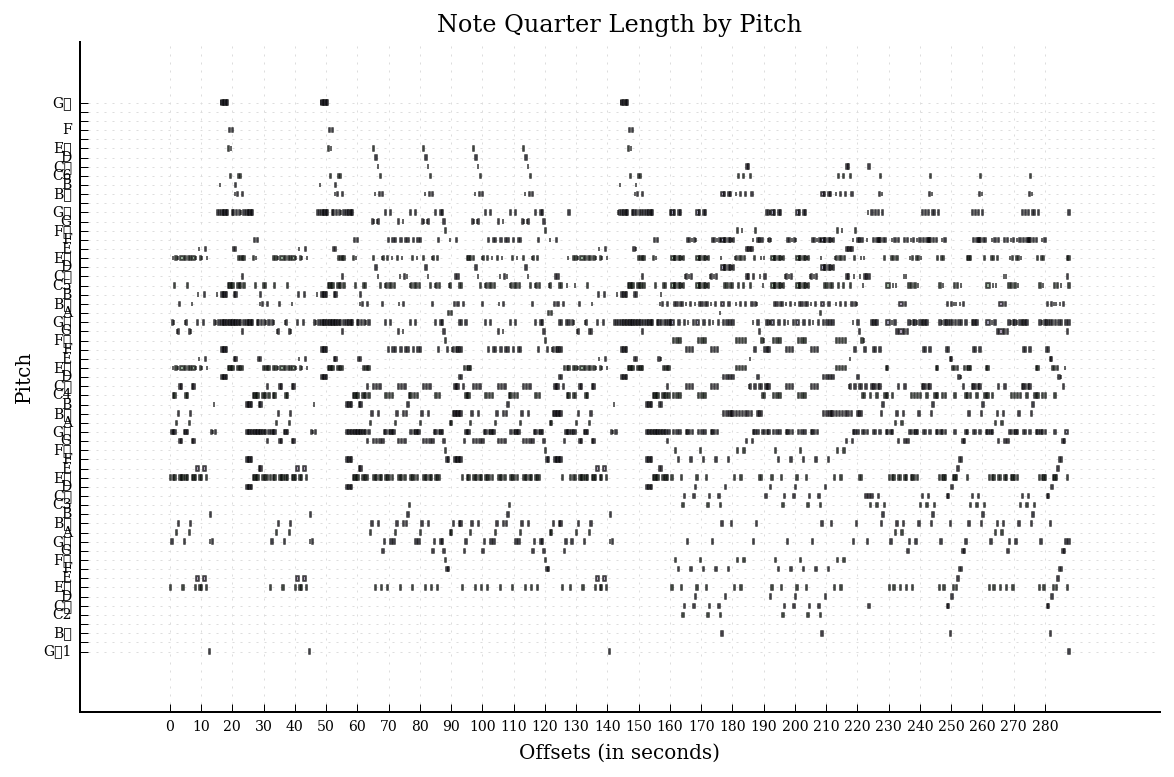

In [3]:
entire_piece.plot('pianoroll',xlabel='Offsets (in seconds)')

#### OBSERVATIONS AND INFERENCES

The repetitions are so visually conspicuous that even an unbiased musically uneducated person can partition this piano-roll into sections AABBACCDD. 
<img src="../resources/images/PianoRoll.jpg">

In [4]:
#To play the initial few samples of this midi file (Section A)
sample=entire_piece[0].flat[0:143] #The stream is flattened so that the elemets could be accessed just like accessing elements of list
realtime_player = midi.realtime.StreamPlayer(sample)
print("Now playing a sample from Maple Leaf Rag ...")
realtime_player.play()
print("Completed playing the sample clip")

Now playing a sample from Maple Leaf Rag ...
Completed playing the sample clip


#### ASSUMPTIONS: 
Throughout the scope of this project:

#1. Treble events are notes/rests/chords meant to be played/honored by the right hand and are referred to as lead part.
#2. Bass events are notes/rests/chords meant to be played/honored by the left hand and are referred to as bass part.

In [5]:
#Let us split the piece into left hand and right hand parts and listen to each hands individually
split=entire_piece.voicesToParts()
left=split.parts[1]
right=split.parts[0]

#Plays the left hand part in the sample
sample_left_stream=stream.Stream()
sample_left_stream.append(sample[:4])
sample_left_stream[0].insert(0,left)
realtime_player = midi.realtime.StreamPlayer(sample_left_stream.flat[0:54])
print("[LEFT] Now playing left hand part in the sample")
realtime_player.play()

#Plays the right hand part in the sample
sample_right_stream=stream.Stream()
sample_right_stream.append(sample[:4])
sample_right_stream[0].insert(0,right)
realtime_player = midi.realtime.StreamPlayer(sample_right_stream.flat[0:85])
print("[RIGHT] Now playing right hand part in the sample")
realtime_player.play()



[LEFT] Now playing left hand part in the sample
[RIGHT] Now playing right hand part in the sample


#### OBSERVATIONS AND INFERENCES

As far as the section played in the previous cell, the individual left hand part(bass) by itself does not make any significant musical sense. The bass plays only supportive role. The right hand part represents the lead portion well as it independently expresses the musicality of the piece. However, when we listen to the righ hand part alone, the bass line ticks are "assumed" since we have heard this piece many times and we are biased. Also, even if we didn't hear this piece before, the basic rhythmic sense sympathetically plays a virtual metronome in our mind and completes the lead melody rhythmically. Therefore, we get the essence of the piece just by listening to the treble portion. However, when the bass is played along with the lead, there is higher "musical satisfaction" because this stimulus aligns well with the bias in listeners' mind which exists in the form of expectations. Also, the bass section further enhances the syncopation. We will analyze the syncopation in the next cell by comparing the onsets of the left and right hand parts.  


## SYNCOPATION

### Essentia Beat Analysis

We shall use Essentia to detect note onsets in the wav file representation of this piece. The next cell is commented out on purpose - please read the comments.

In [6]:
##This block is commented as the midi files(left_sample.mid and right_sample.mid) and their corresponding wav files are already extracted
##Used this code to generate midi files for left hand and right hand parts

#sample_left_stream.write('midi','../resources/audio/left_sample.mid')
#sample_right_stream.write('midi','../resources/audio/right_sample.mid')

##Once we get the midi files, we can use the command "timidity input.mid -Ow -o out.wav" from the terminal to get the wav files
##NOTE: Need not run this block as the required files(.mid and .wav) have already been extracted

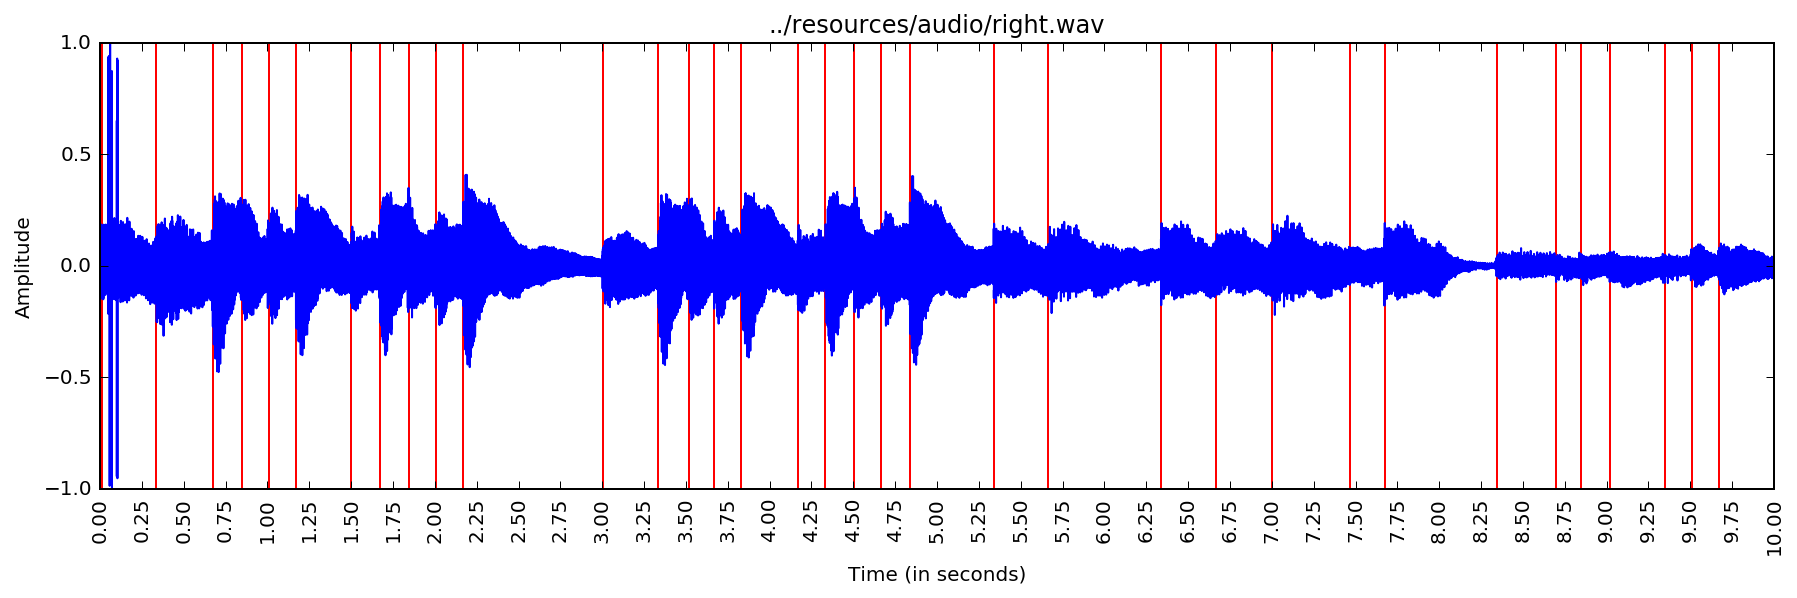

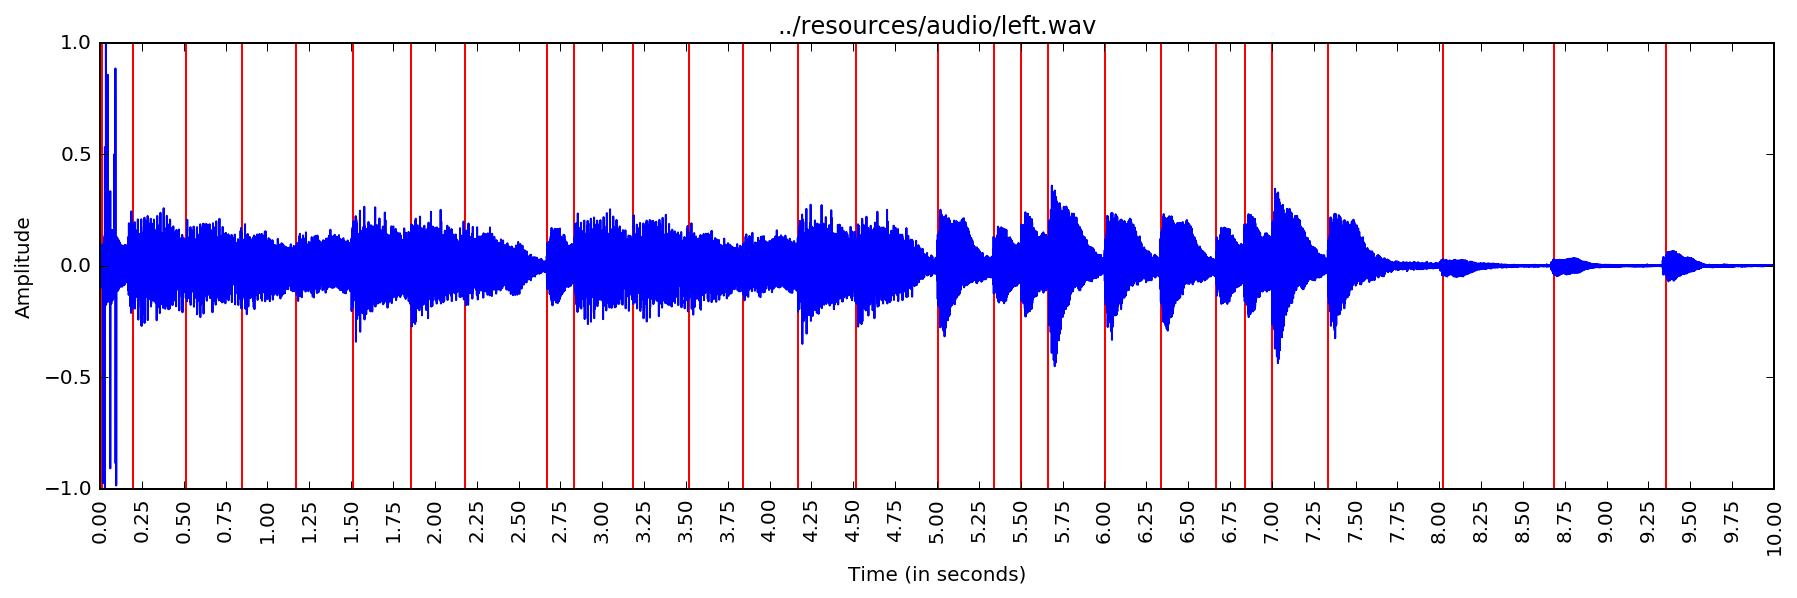

In [8]:
# Essentia Beat Detection 
wavFileNames=['../resources/audio/right.wav','../resources/audio/left.wav']
fs = 44100 # Sampling rate
durInSecs=10 # duration of the wav file under consideration
t=np.arange(durInSecs*fs)/float(fs) # setting the time axis
zero_array=t*0 # used only for plotting purposes
windowSize=1024
hopSize=256

#Loading Essentia functions required
# See Essenatia tutorial example: 
# https://github.com/MTG/essentia/blob/master/src/examples/tutorial/example_onsetdetection.py
od_complex = OnsetDetection(method='complex')#Onsets will be detected using complex spectral difference
w = Windowing(type = 'hann')
fft = FFT() # this gives us a complex FFT
c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
onsets = Onsets()
onset_parts=[]
for fileName in wavFileNames:
    #fileName = os.path.join(soundsDir, file)
    x = MonoLoader(filename = fileName, sampleRate = fs)()
    x = x[:durInSecs*fs]#let's use only the first 10 seconds of the signals
    x = x/np.max(np.abs(x))# normalizing input signal
    
    #Plotting
    f, axarr = plt.subplots(1,1,figsize=(15, 4))
    axarr.plot(t,x);axarr.set_title(fileName);
    plt.xticks(np.arange(0,10.25,0.25), rotation='vertical')
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Amplitude")
    #Essentia beat tracking
    pool = Pool()
    for frame in FrameGenerator(x, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.complex', od_complex(mag, phase))#Onsets will be detected using complex spectral difference
    
    onsets_complex = onsets(array([pool['features.complex']]),[1])
    onsets_complex = onsets_complex[onsets_complex<durInSecs]
    onset_parts.append(onsets_complex)
    np.savetxt(fileName.replace('.wav','_est_complex.txt'), onsets_complex, delimiter='\n',fmt='%f')
    axarr.vlines(onsets_complex, -1, 1, color='r')
    
    

Let us compute the performance of the Essentia onset detector in the next cell.

In [8]:
#Compute accuracy
left_true_onsets=np.array([])
for element in left.flat:
    if(element.offset>10):#As we estimated onsets only for the first 10 seconds 
        break
    left_true_onsets=np.append(left_true_onsets,element.offset)
    
right_true_onsets=np.array([])
for element in right.flat:
    if(element.offset>10):#As we estimated onsets only for the first 10 seconds
        break
    right_true_onsets=np.append(right_true_onsets,element.offset)
    
F_left, P_left, R_left = mir_eval.onset.f_measure(left_true_onsets,onset_parts[1])
print("Onset detection F1 Measure for [LEFT] part is "+str(F_left))
F_right, P_right, R_right = mir_eval.onset.f_measure(right_true_onsets,onset_parts[0])
print("Onset detection F1 Measure for [RIGHT] part is "+str(F_right))

Onset detection F1 Measure for [LEFT] part is 0.25
Onset detection F1 Measure for [RIGHT] part is 0.233333333333


#### OBSERVATIONS AND INFERENCES

#### NOTE : The onsets are detected for the wav file. The plots show that the Essentia's onset detectors are performing well since the onset markers seem to match the note onsets. But the ground truth that we are using is from the MIDI file. The wav file which was converted from MIDI definitely has some information loss/errors. We had to convert MIDI to wav file for the following reasons:
* The data availabe is only in mp3 and MIDI format.
* For onset detection to work well, Essentia needs wav files.
* We might have considered converting mp3 to wav file, but we needed to separate out left and right hand parts which would have been harder. So, instead we made use of MIDI file to separate out left and right parts and then convert each of them to wav file. 

It is very clear that, Essentia's onsets seem to be correct for the wav file, if we look at the plots closely. We can comment on the offset distribution by looking at the markers. 

From the above 2 plots, it is clear that bass(left.wav) traces the metronome more closely. The onsets are spaced more uniformly in left hand parts than compared to the right hand parts. We see evenly spaced onsets in right hand parts between two onsets in the left hand parts. This is actually representing a lead onset on the upbeat. This is exactly what syncopation means. The melody formed by right hand is concentrated over the upbeats. The syncopation is there throughout the ragtime piece and is the defining feature of ragtime genre. 

### MIDI Analysis

It is better to use MIDI for analysis than the wav file, mainly because we do not have the audio in wav file format. Also, even the best MIR algorithms will not get us results which are as good as the data available in MIDI file which in some circumstances the ground truth(for example: note onsets). Also, piano ragtime pieces do not have much dynamics that MIDI encoding misses unlike other genres. We will stick to the MIDI data analysis since this domain will give us better results than the audio representation for this style of music.

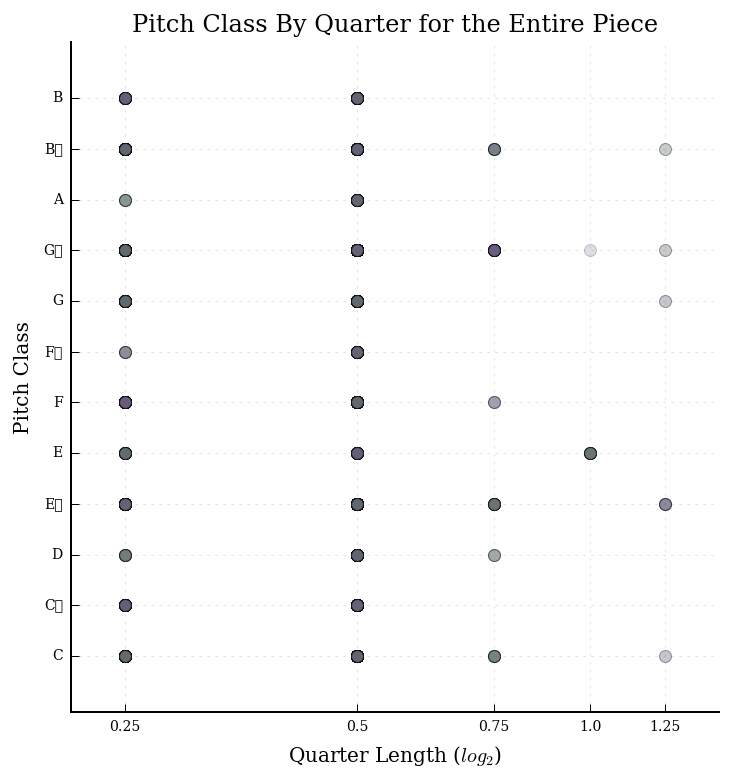

In [9]:
# Plotting pitchClass vs quarterLength to look at the distribution of lengths occupied by each pitchClass  
entire_piece.plot('scatter', 'pitchClass', 'quarterLength',title='Pitch Class By Quarter for the Entire Piece')

#### NOTE: There seems to be a bug in music21 which is not allowing me to rename the xaxis label as 'seconds' in the plot above.


#### OBSERVATIONS AND INFERENCES

The above plot does not tell us much about the syncopation. But it does reveal that majority of the notes are half-notes. The second highest category comprises of notes that are quarter length long. However, we need look at the onsets of the notes to visualize the syncopation. And to do that, it is better to juxtapose the onsets of right hand and left hand parts and compare. 

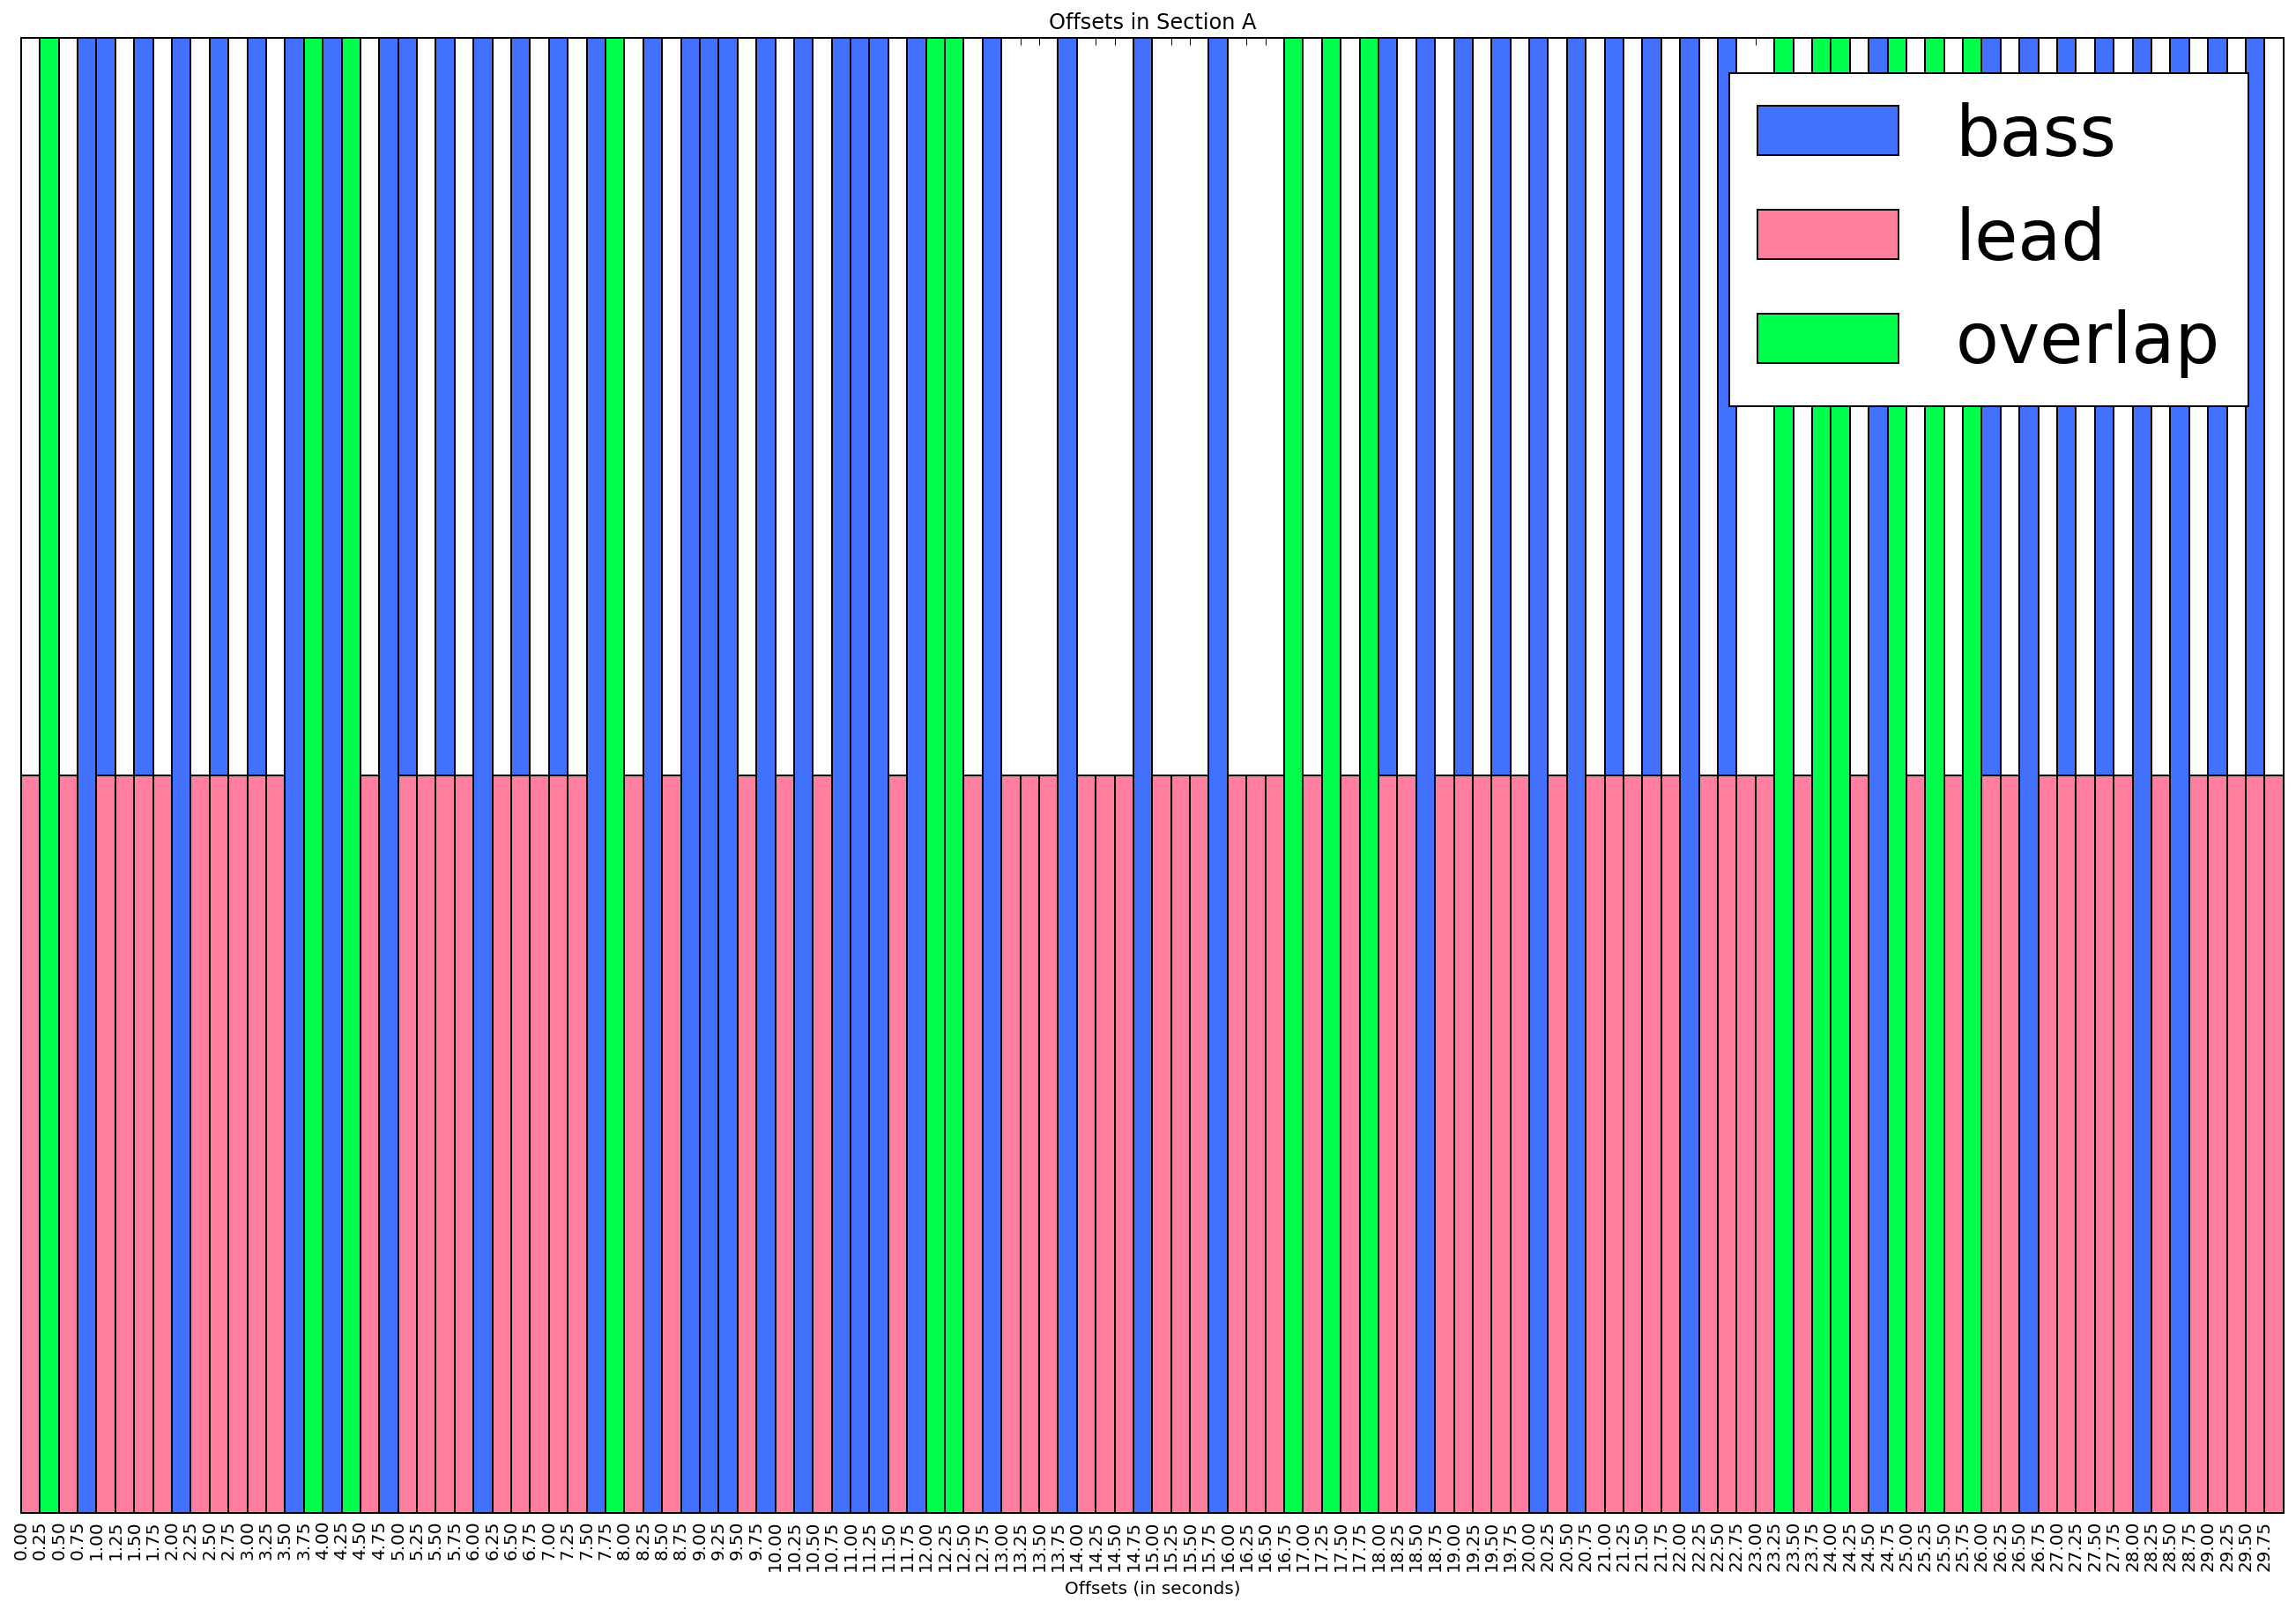

In [10]:
# In this code segment we extract the offsets for left and right hand parts
left_offsets=set()
right_offsets=set()

for element in left.flat:
    left_offsets.add(element.offset)

for element in right.flat:
    right_offsets.add(element.offset)

offsets=np.array(sorted(left_offsets|right_offsets))

    
# We plot both the offsets in a single graph to view the overlap/syncopy
#To plot both the left and right parts, we need xaxis which contains all the intervals. 
#Once we get xaxis, we need to add 0s in the left and right parts accordingly such that they are of the same sise as xaxis.
step_size=min(abs(offsets[:-1]-offsets[1:]))
min_value=min(offsets)
max_value=max(offsets)
xaxis=np.arange(min_value,max_value,step_size)
left_offsets_array=np.copy(xaxis)
right_offsets_array=np.copy(xaxis)

for offset in xaxis:
    left_offsets_array[np.where(left_offsets_array==offset)]=int(offset in left_offsets)
    right_offsets_array[np.where(right_offsets_array==offset)]=int(offset in right_offsets)*0.5 #To visual distinguish the heights of bars

#To find the overlapping points in first 120 offsets    
overlap=np.zeros(120)
overlap[np.where(left_offsets_array[:120]==right_offsets_array[:120])]=1

#To plot the bass, lead and overlap bars with respect to the offset time
plt.figure(figsize=(23, 15))
width = step_size
plt.bar(xaxis[:120], left_offsets_array[:120],width,color=(0.2588,0.4433,1.0),label='bass')
plt.bar(xaxis[:120],right_offsets_array[:120],width,color=(1.0,0.5,0.62),label='lead')
plt.bar(xaxis[:120],overlap,width,color=(0.0,1.0,0.3),label='overlap')

plt.xticks(np.arange(0,30,0.25),rotation='vertical')
plt.xlabel('Offsets (in seconds)')
plt.yticks([])
plt.title('Offsets in Section A')
plt.rc('legend',**{'fontsize':40})
plt.legend()
plt.show()    

#### OBSERVATIONS AND INFERENCES

The pink bars represent the treble events and the blue bars represent the bass events. It can be clearly seen that blue bars mostly occur at multiples of 0.5 and pink bars occur at multiples of 0.25. The pink bars occuring at odd multiples of 0.25 are responsible for syncopation. The odd multiples of 0.25 correspond to upbeat. The blue bars are longer than pink bars to make it visibly clear. When both the blue and pink bars occur together, green bar is shown for overlap.


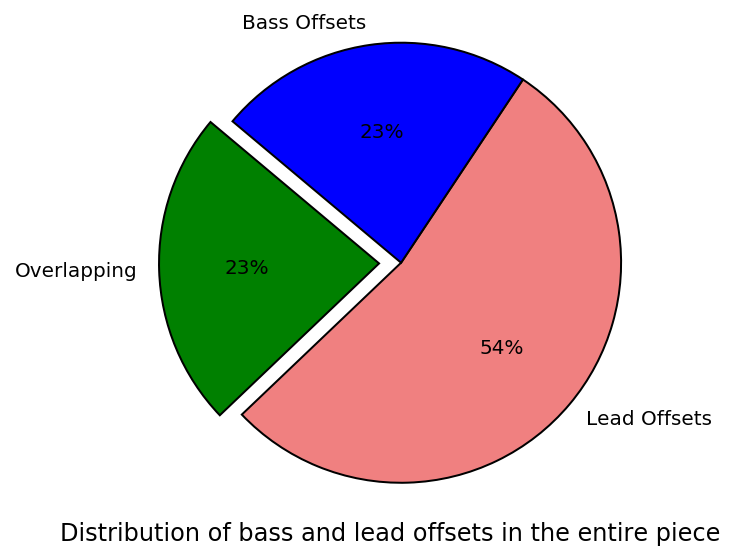

In [11]:
#Calculate distribution of overlaps, bass and treble events throughout the piece
overlap = sorted(set.intersection(left_offsets,right_offsets))
xs_lead = sorted(right_offsets.difference(overlap))
xs_bass = sorted(left_offsets.difference(overlap))

# Plotting the % overlap and non-overlap
labels = 'Overlapping', 'Lead Offsets', 'Bass Offsets'
fracs = [len(overlap)*100/len(offsets), len(xs_lead)*100/len(offsets), len(xs_bass)*100/len(offsets)]
colors = ['green', 'lightcoral', 'blue']
explode = (0.1, 0, 0)
plt.pie(fracs, explode=explode, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=False, startangle=140)
 
plt.axis('equal')
plt.title('Distribution of bass and lead offsets in the entire piece',y=-0.15)
plt.show()

#### OBSERVATIONS AND INFERENCES

This distribution gives us an insight that the bass events and treble events overlap only for <25% of the piece. Also, bass events(23+23=46%) are fewer than the treble events(23+54=77%). This is indicative of dominance of treble events that we discussed earlier. In the next cell, we illustrate the manifestation of syncopy by plotting the frequency distribution of offsets within each measure for the entire left hand part and right hand part.

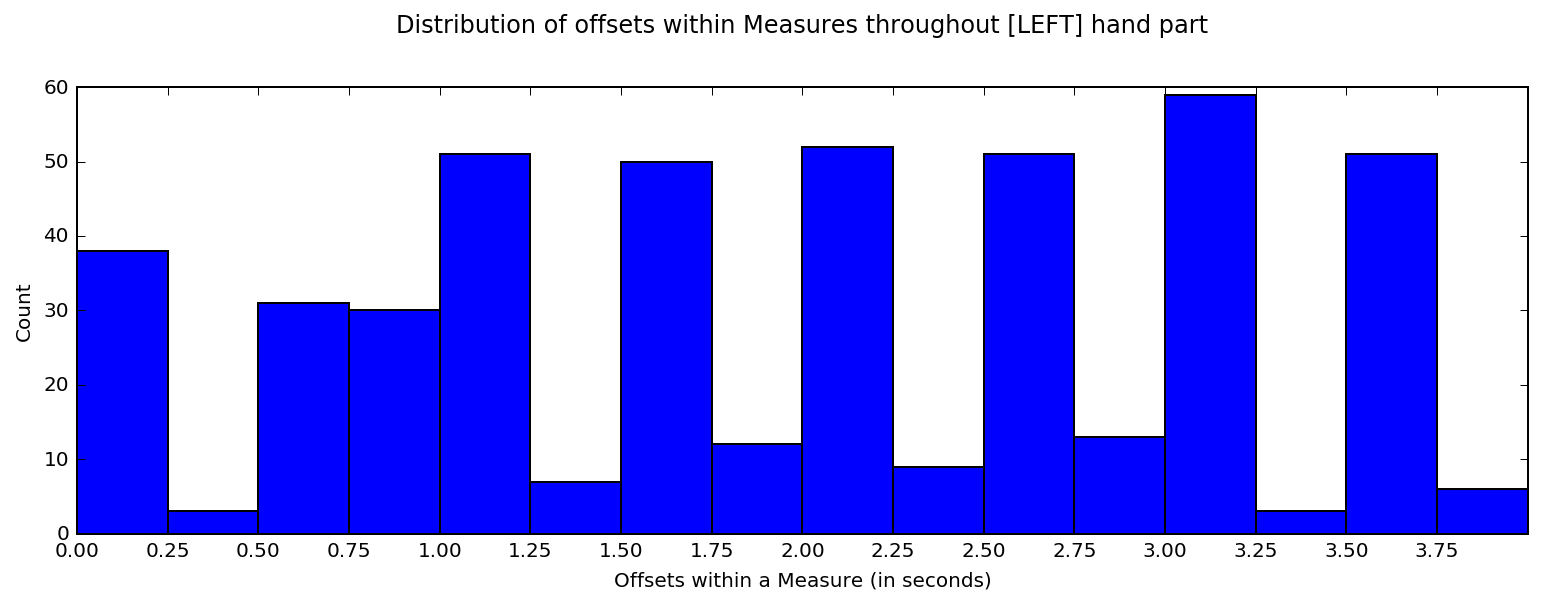

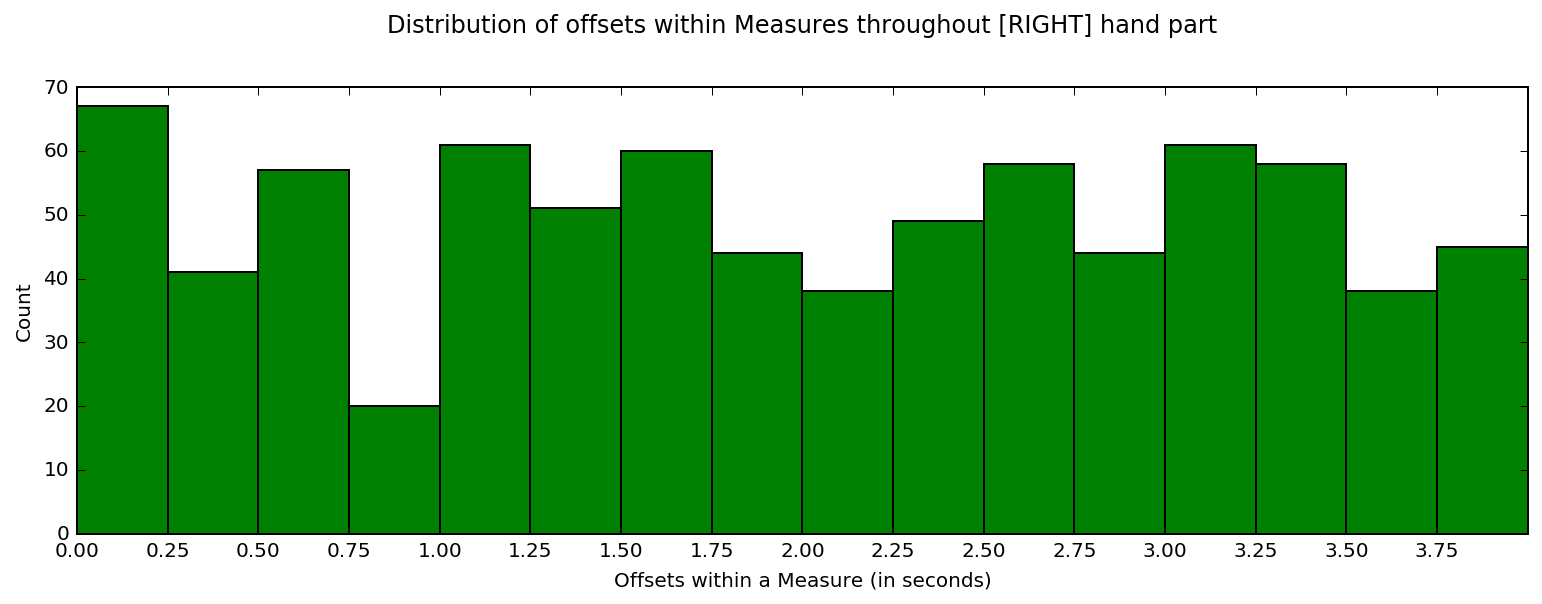

In [12]:
#Get all the measures from the score for each left and right segments
left_measures=left.measures(0,145)
right_measures=right.measures(0,145)

#To get distribution of offsets within Measures throughout [LEFT] hand part
list_offsets_within_measure=[]
for item in left_measures:
    if(type(item)!=stream.instrument.Piano and type(item)!=stream.key.Key):
        for element in item.elements:
            if(type(element)!=clef.BassClef and type(element)!=meter.TimeSignature and type(element)!=bar.Barline):
                list_offsets_within_measure.append(element.offset)
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
left_offset_distribution=Counter(list_offsets_within_measure)

#To get distribution of offsets within Measures throughout [RIGHT] hand part
list_offsets_within_measure=[]
for item in right_measures:
    if(type(item)!=stream.instrument.Piano and type(item)!=stream.key.Key):
        for element in item.elements:
            if(type(element)!=clef.BassClef and type(element)!=meter.TimeSignature and type(element)!=bar.Barline):
                list_offsets_within_measure.append(element.offset)
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
right_offset_distribution=Counter(list_offsets_within_measure)

# Plotting the distributions
width=0.25
plt.figure(figsize=(13,4))
plt.bar(left_offset_distribution.keys(), left_offset_distribution.values(), width, color='b')
plt.title('Distribution of offsets within Measures throughout [LEFT] hand part',y=1.1)
plt.xlabel('Offsets within a Measure (in seconds)')
plt.ylabel('Count')
plt.xticks(np.arange(0,4,0.25))
plt.show()

plt.figure(figsize=(13,4))
plt.bar(right_offset_distribution.keys(), right_offset_distribution.values(), width, color='g')
plt.title('Distribution of offsets within Measures throughout [RIGHT] hand part',y=1.1)
plt.xlabel('Offsets within a Measure (in seconds)')
plt.ylabel('Count')
plt.xticks(np.arange(0,4,0.25))
plt.show()

#### OBSERVATIONS AND INFERENCES

Now, it is very clear that within each measure, left hand parts are mostly distributed at integral multiples of 0.5. The same is true for right hand part. But, from the analysis in previous section, we notice that the overlap is only 23%. We can also notice that at odd multiples of 0.25, bass events(blue) have very low counts, while the treble events(green) have higher counts. These are responsible for syncopation as odd multiples of 0.25 correspond to upbeat for this piece.


In the next section, we will analyze the tonality of this piece-the melodic centres in sections, most common chords, most and discuss specialities of each section among other interesting things!

## TONALITY

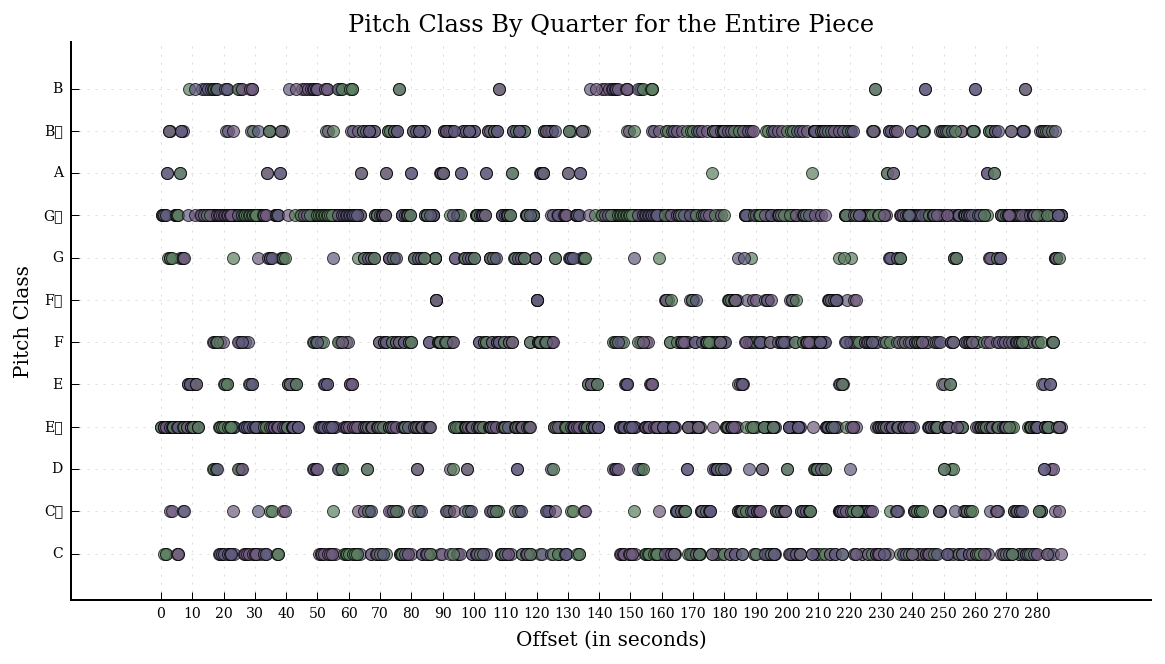

In [13]:
#Plot the pitch class scatter plot for the entire piece
entire_piece.plot('scatter', 'pitchClass', 'offset',title='Pitch Class By Quarter for the Entire Piece',xlabel='Offset (in seconds)')

#### OBSERVATIONS AND INFERENCES

From the plot above, the pitch class Aflat is the most occuring one in the piece. This is not surprising since the piece is in Aflat key. The next most occuring pitch class is Eflat. Eflat is the perfect fifth of Aflat. We can expect the pitch classes involved in major chord triad with Aflat as the root note to have a significant presence in this piece. As expected, we already saw that Aflat and Eflat are dominant. The third note of this major chord triad, C is the next most occuring pitch class, as expected. The next most common pitch class is Bflat which forms a sus2 chord with Aflat and Eflat and it is also the perfect fifth of Eflat.

In the decreasing order of counts, the following is the pitch class distribution:
{Aflat, Eflat, C, Bflat, F, Dflat, B, G, D, A, F#, E}


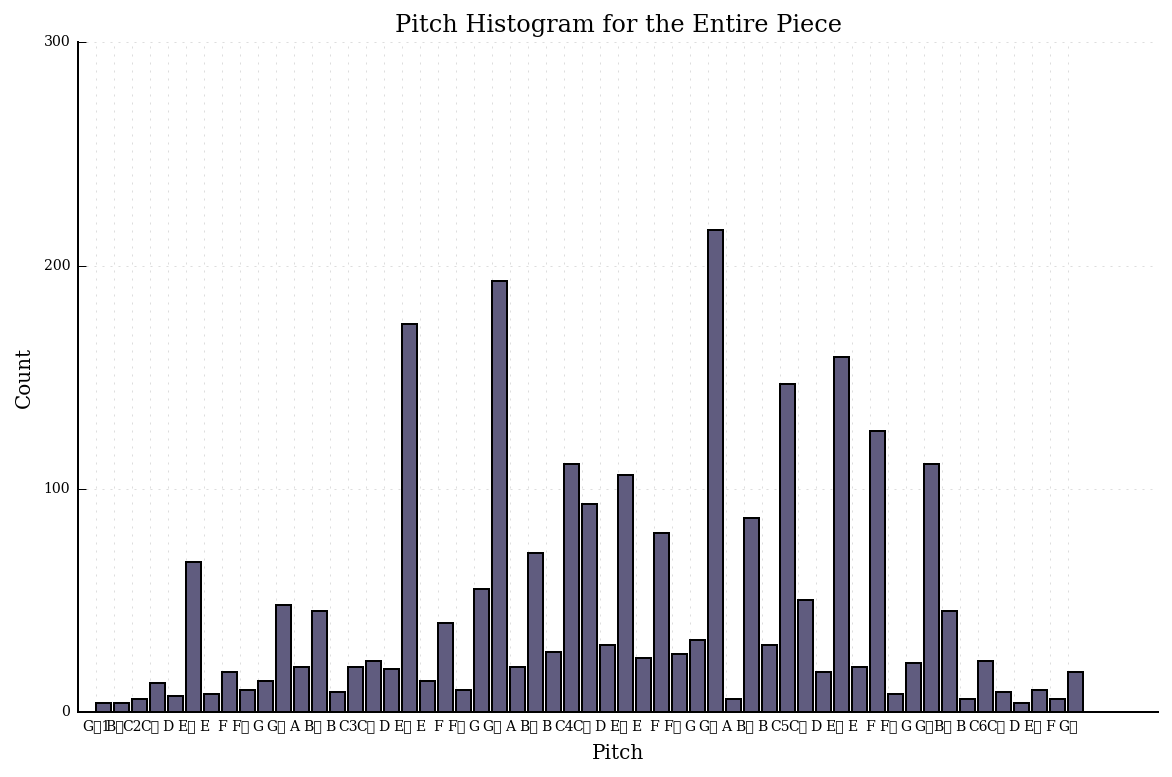

In [14]:
#Plot pitch histogram for the overall track
entire_piece.plot('histogram', 'pitch',title='Pitch Histogram for the Entire Piece')

#### OBSERVATIONS AND INFERENCES

The above plot is different from the previous plot as we have pitch information with the octave information unlike the pitch class plot. The Aflat4 is the most occuring pitch followed by Aflat3. Eflat3 is the next highest occuring pitch followed by Eflat4. It is interesting that the same pitch from different octaves have similar counts. This is indicative of the presence of octave unision chords.

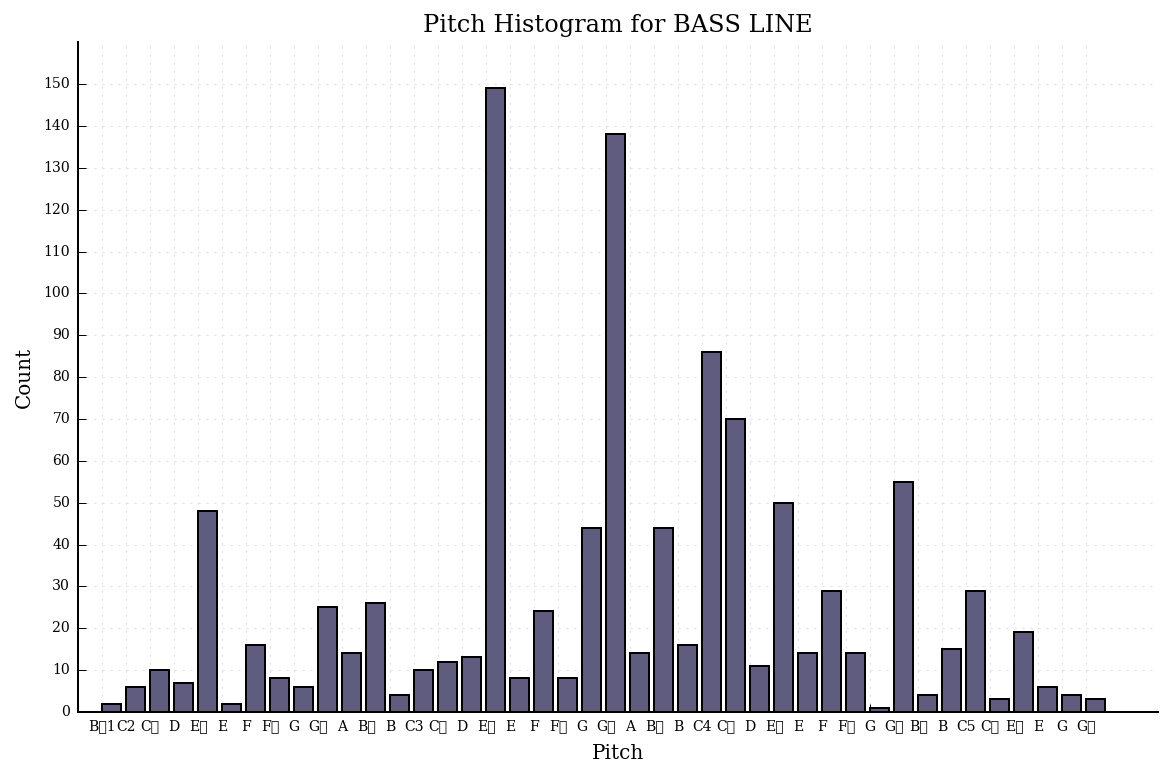

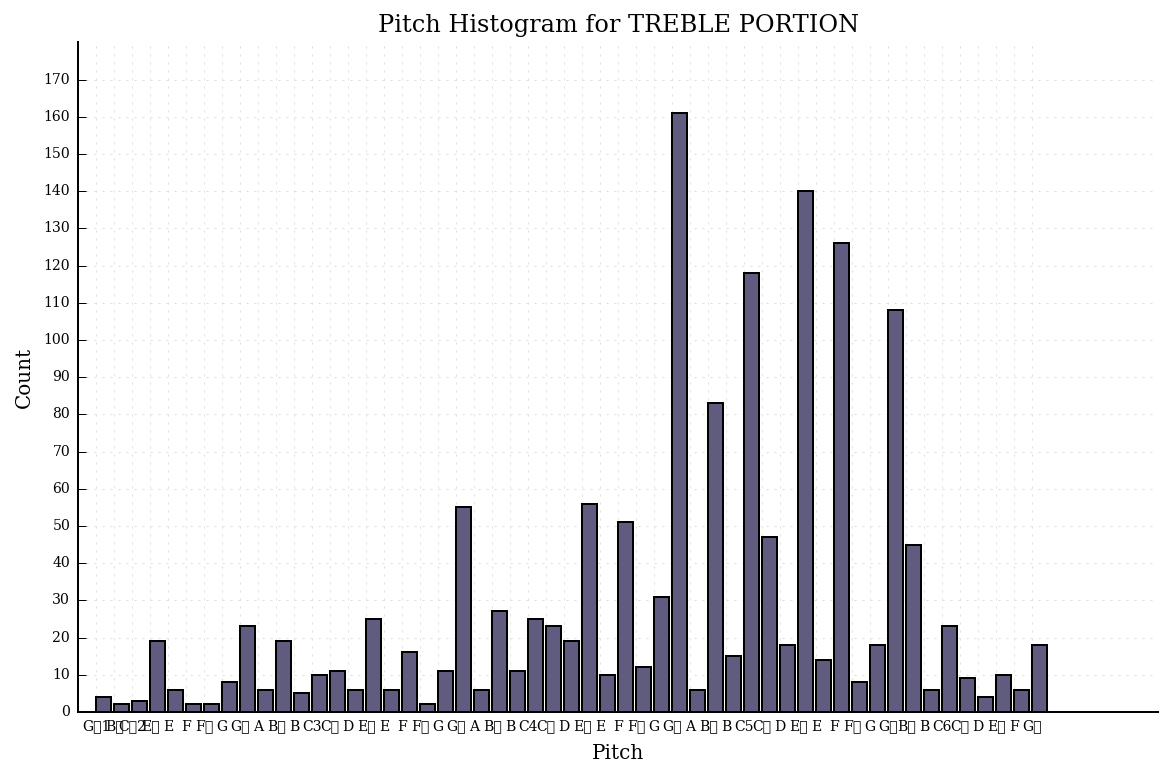

In [15]:
# Plot pitch histograms for left and right parts separately
left.plot('histogram', 'pitch',title='Pitch Histogram for BASS LINE') #pitch histogram for the left hand parts
right.plot('histogram', 'pitch',title='Pitch Histogram for TREBLE PORTION') #pitch histogram for the right hand parts

#### OBSERVATIONS AND INFERENCES

Analyzing the left and right hand parts give us more insight rather than analyzing the entire piece as such. As expected, we see that the bass line has more distribution of notes in lower octaves and treble portion has higher note distribution in the upper octaves. Most important note in Bassline is Eflat3 followed by Aflat3. It is interesting to note that the perfect fifth of the key of the piece - Aflat is the most important note in the bassline. In Treble section, the most important note is Aflat4 which is same as the key of the piece, followed by Eflat5(the perfect fifth of Aflat). This implies that the perfect fifth relations are very important in this piece.  

In the next cell, we will do a key analysis of the entire piece with variable length windows and use Krumhansl Schmuckler Key Analysis to determine the key for each window and look at the variation in distribution of keys with change in window size.

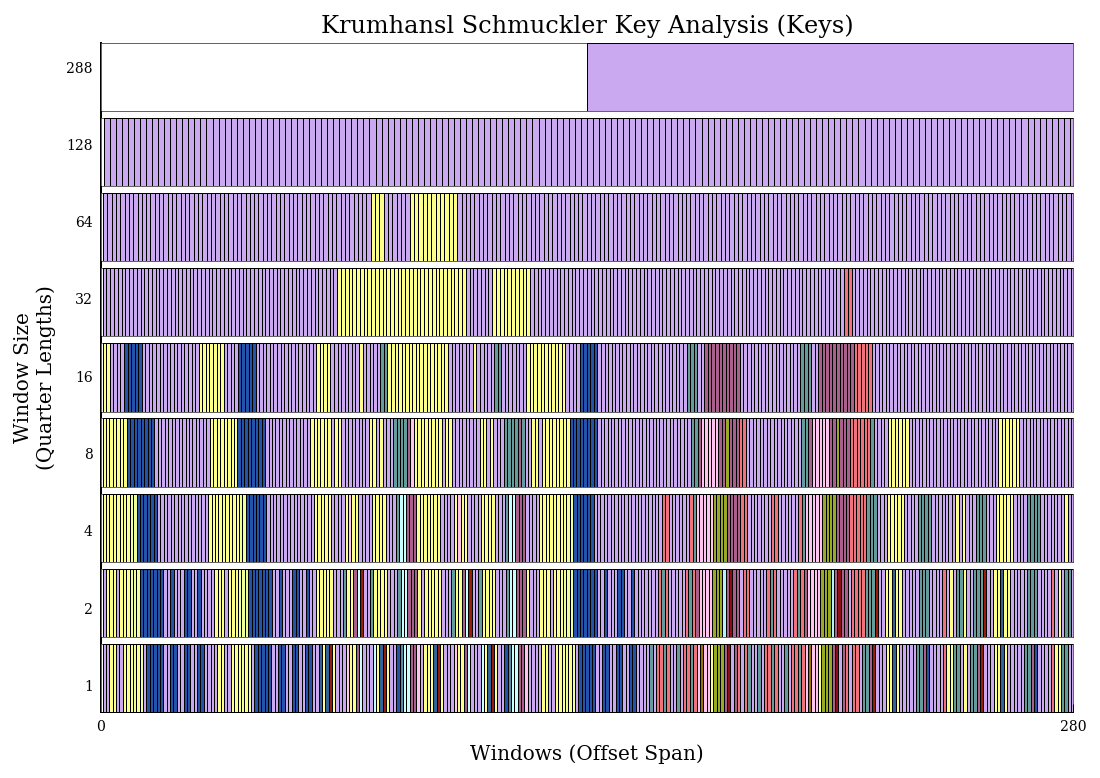

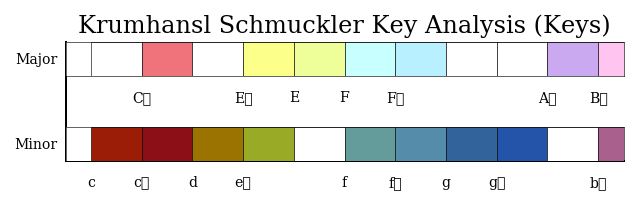

In [16]:
#Krumhansl Schmuckler Key Analysis
p = graph.plot.WindowedKey(entire_piece.parts[0])
p.id
p.run()

#### OBSERVATIONS AND INFERENCES

The above analysis is analogous to Set-Class Explorer applied for Key Analysis. We analyze the entire piece with different window sizes and plot the results for all the window sizes. Krumhansl Schmuckler Key Analysis is used to determine the key for a window. As the window size increases, we finally end up with the key of the piece - Aflat. As and when we reduce the window size, we need to look at the new keys that show up and use this information to build tonal hierarchy. When we keep reducing the window size, we get more keys and we can see that the distribution of the keys changes. The key distribution is sparse for large window sizes and dense fo small window sizes. 

In the next cells, we split the piece into sections A, B, C and D and look at the tonal distributions.

In [17]:
#Each section has equal number of measures : 16
a=entire_piece.parts[0].measures(2,17)
b=entire_piece.parts[0].measures(34,49)
c=entire_piece.parts[0].measures(82,97)
d=entire_piece.parts[0].measures(114,129)

#Uncomment the following lines in the cell to listen to each section
#realtime_a = midi.realtime.StreamPlayer(a)
#realtime_b = midi.realtime.StreamPlayer(b)
#realtime_c = midi.realtime.StreamPlayer(c)
#realtime_d = midi.realtime.StreamPlayer(d)

#print("[SECTION A] is playing)
#realtime_a.play()
#print("[SECTION B] is playing)
#realtime_b.play()
#print("[SECTION C] is playing)
#realtime_c.play()
#print("[SECTION D] is playing)
#realtime_d.play()

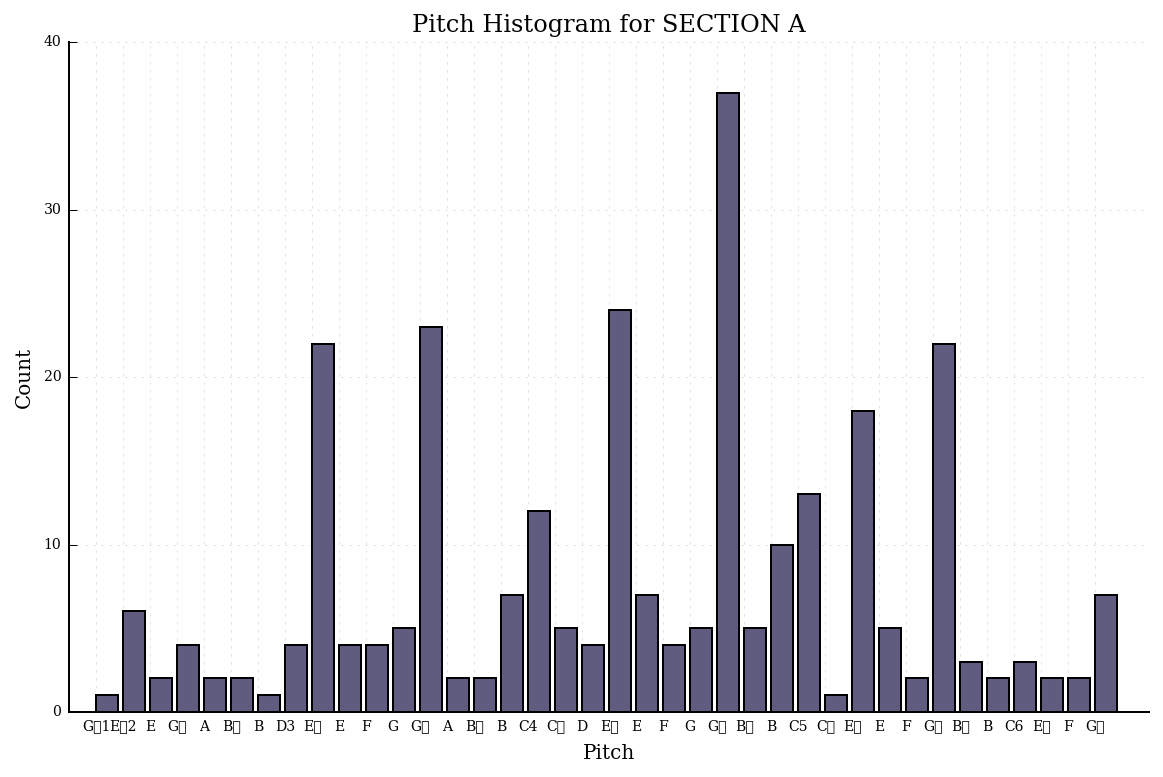

In [18]:
a.plot('histogram', 'pitch',title='Pitch Histogram for SECTION A')

#### OBSERVATIONS AND INFERENCES

Aflat4(G#4) is the tonal center in Section A. The melodies revolve around this note. Next important note is Eflat4(the perfect fifth of Aflat). We see that these pitches are important since the notes from different octaves having same pitch have significant presence in this piece.

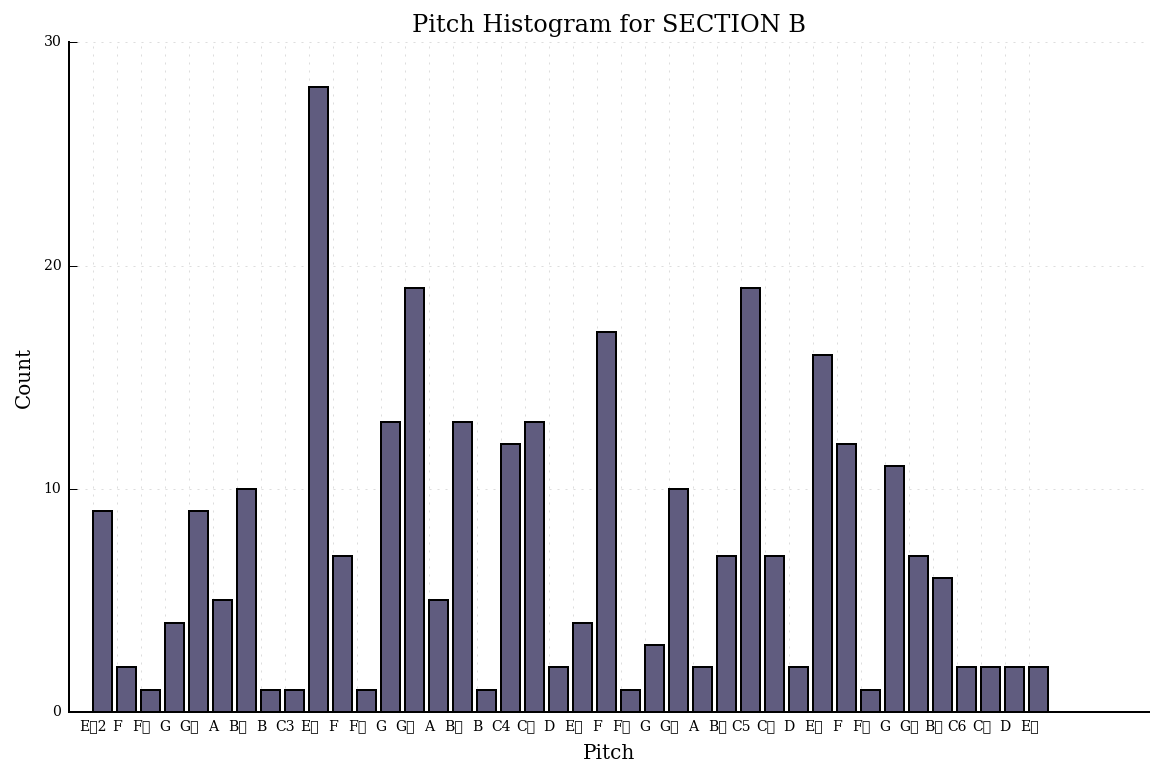

In [19]:
b.plot('histogram', 'pitch',title='Pitch Histogram for SECTION B')

##### OBSERVATIONS AND INFERENCES

The tonal center shifted from Aflat4(G#4) in Section A to Eflat3 in Section B. The tonal center moved down the octave. Eflat is perfect fifth of Aflat. The next important notes are Aflat3(G#3) followed by C5. C is the major third of Aflat. The melody in this section revolves around Eflat3. 

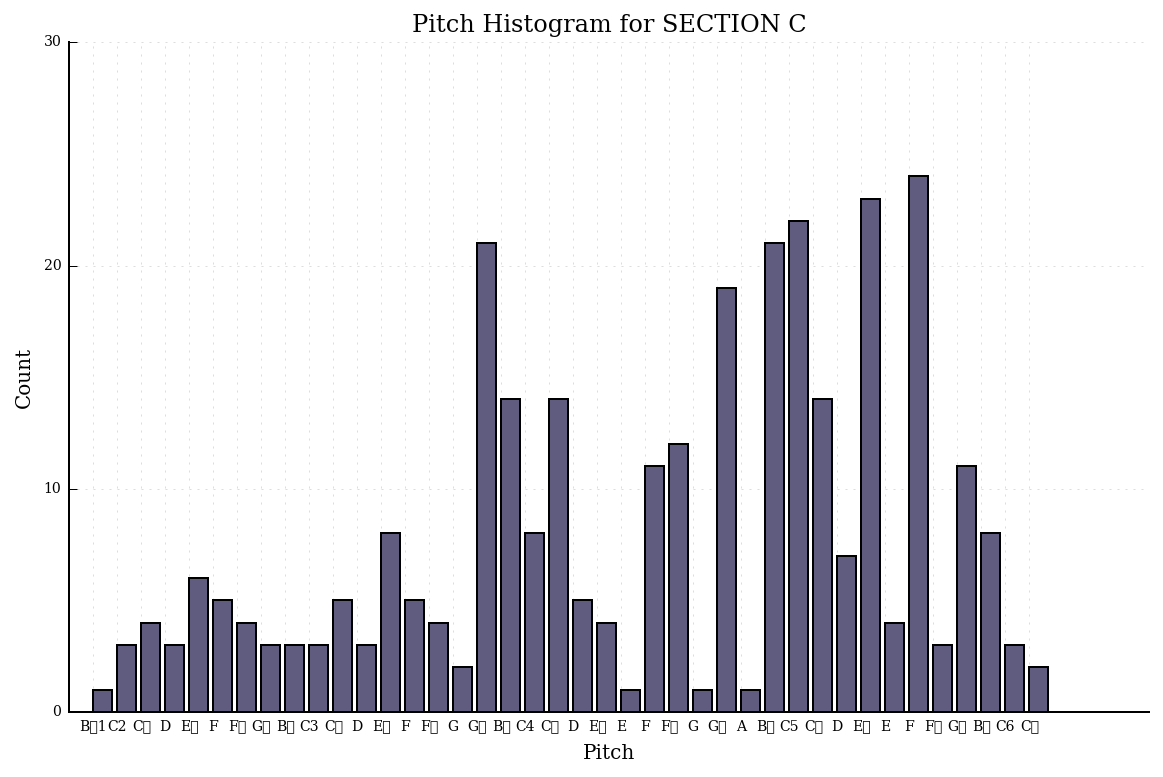

In [20]:
c.plot('histogram', 'pitch',title='Pitch Histogram for SECTION C')

#### OBSERVATIONS AND INFERENCES

In Section C, the tonal center shifts to F5. The next important note is Eflat5. The distribution is high in the upper octaves than the lower octaves in this section. This is indicative of melodic development in higher octaves. Also, the distributions of same notes from different octaves are high. This is expected since we have octave jumps in this sections and a large number of unision chords made of two notes separated by an octave.

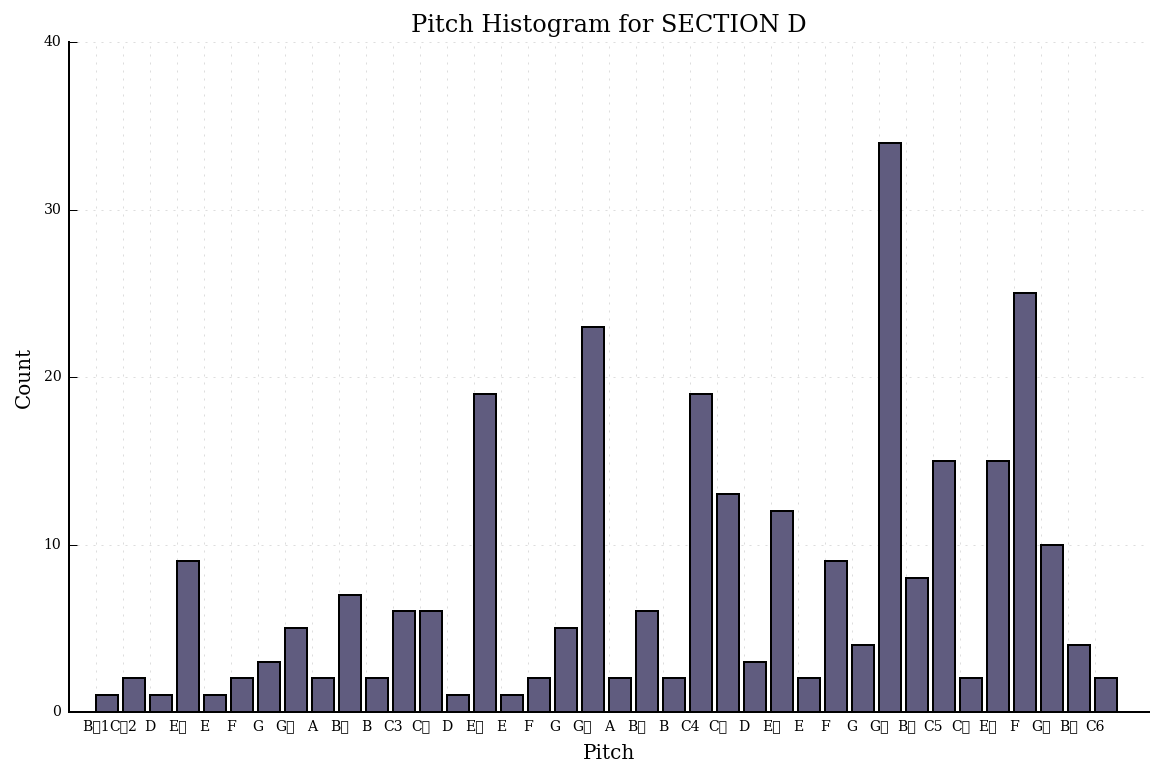

In [21]:
d.plot('histogram', 'pitch',title='Pitch Histogram for SECTION D')

#### OBSERVATIONS AND INFERENCES

The tonal center is back to Aflat4(G#4). The piece started with Aflat4(G#4), moved to Eflat3, then F5 and finally back to Aflat4(G#4). This is indicative of home coming and hints that this is the last section of the piece. F5 is the next important note followed by Aflat3(G#3) and then by C4 and Eflat3.

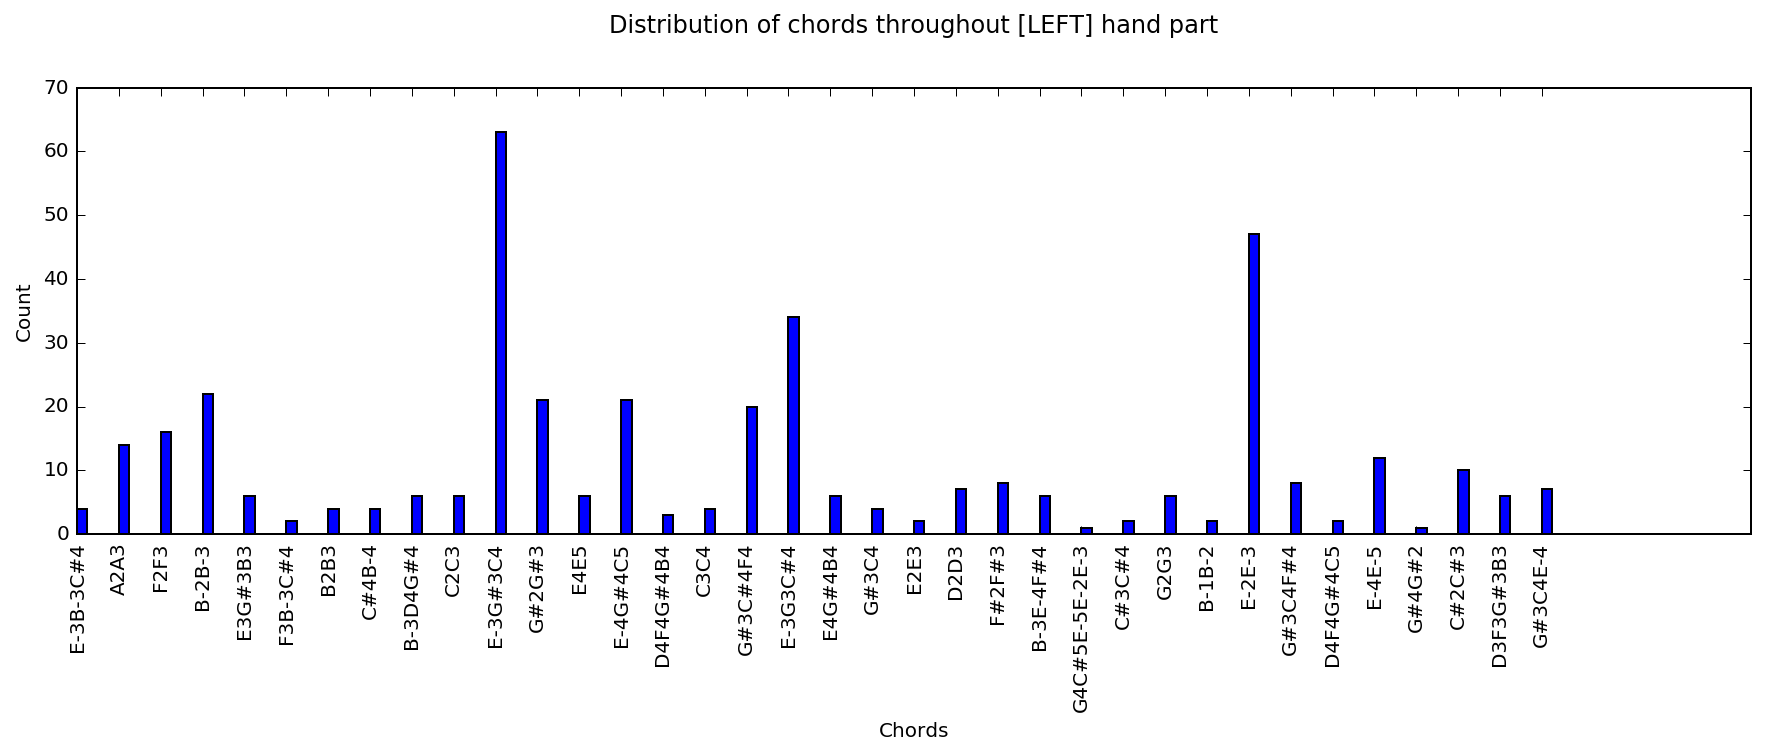

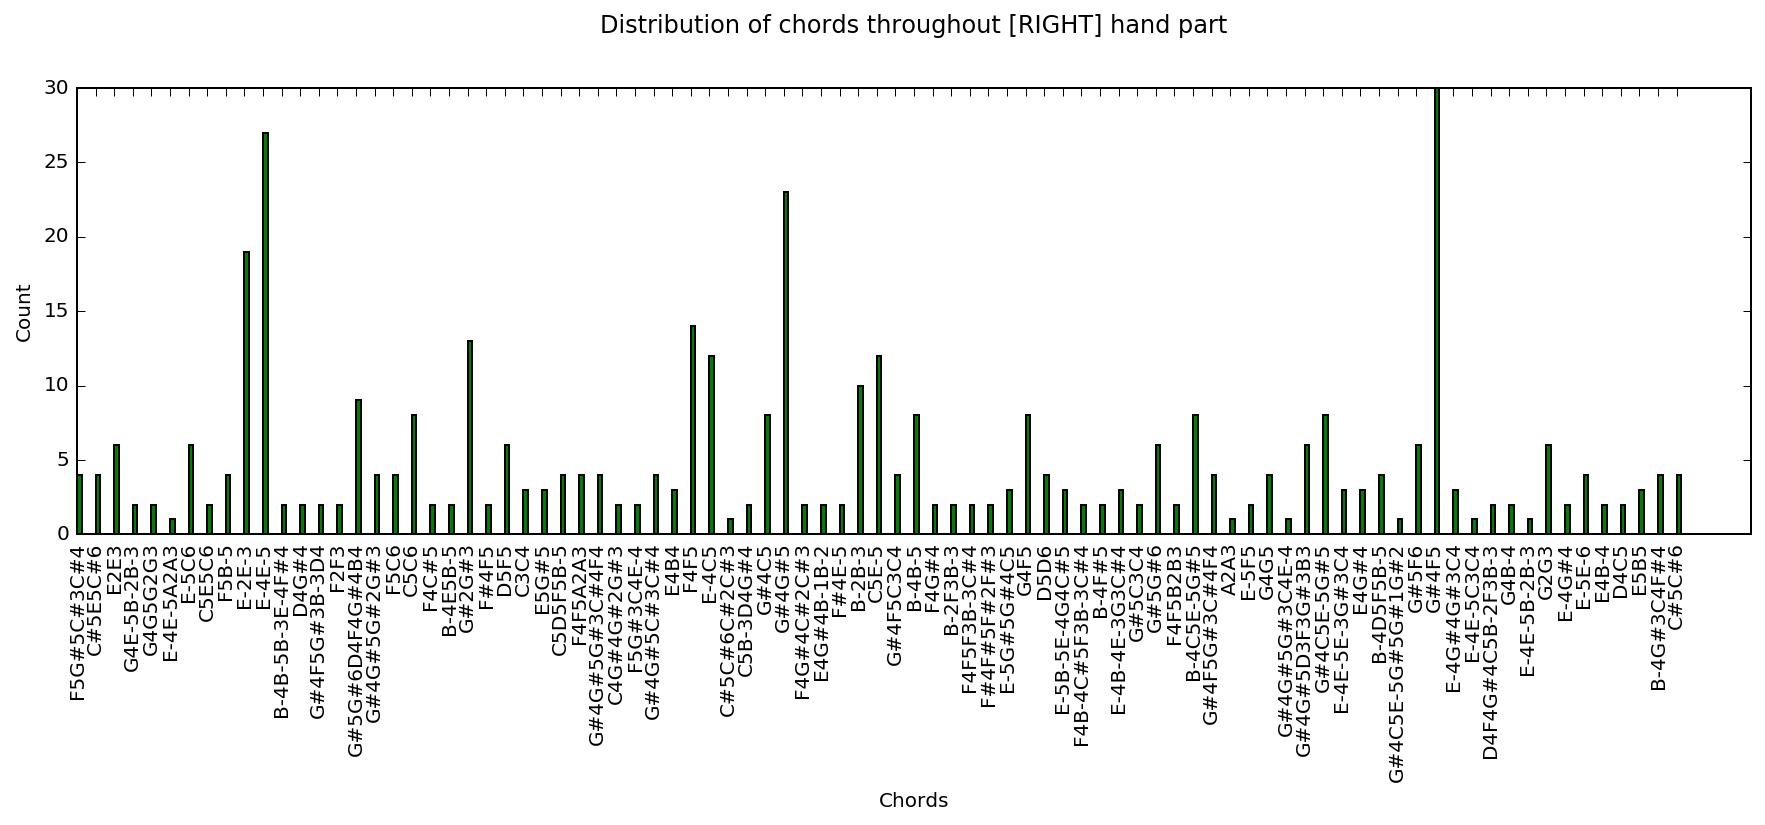

In [22]:
#To get distribution of chords within Measures throughout [LEFT] hand part
list_of_chords=[]
for item in left_measures:
    if(type(item)!=stream.instrument.Piano and type(item)!=stream.key.Key):
        for element in item.elements:
            if(type(element)==chord.Chord):
                notes=[]
                for pitch in element.pitches:
                    notes.append(str(pitch))
                list_of_chords.append("".join(notes))
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
left_chords_distribution=Counter(list_of_chords)

#To get distribution of offsets within Measures throughout [RIGHT] hand part
list_of_chords=[]
for item in right_measures:
    if(type(item)!=stream.instrument.Piano and type(item)!=stream.key.Key):
        for element in item.elements:
            if(type(element)==chord.Chord):
                notes=[]
                for pitch in element.pitches:
                    notes.append(str(pitch))
                list_of_chords.append("".join(notes))
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
right_chords_distribution=Counter(list_of_chords)

# Plotting the distributions
width=0.25
plt.figure(figsize=(15,4))
labels=list(left_chords_distribution.keys())
xaxis=np.arange(0,len(labels))
plt.bar(xaxis, left_chords_distribution.values(), width, color='b')
plt.title('Distribution of chords throughout [LEFT] hand part',y=1.1)
plt.xlabel('Chords')
plt.ylabel('Count')
plt.xticks(xaxis,labels,rotation='vertical')
plt.show()

plt.figure(figsize=(15,4))
labels=list(right_chords_distribution.keys())
xaxis=np.arange(0,len(labels))
plt.bar(xaxis, right_chords_distribution.values(), width, color='g')
plt.title('Distribution of chords throughout [RIGHT] hand part',y=1.1)
plt.xlabel('Chords')
plt.ylabel('Count')
plt.xticks(xaxis,labels,rotation='vertical')
plt.show()

#### OBSERVATIONS AND INFERENCES

The number of chords in bass region is less than that of the treble region. As we listened to the indiviual left and right parts earlier, we notice that the treble parts contribute more to the musicality of this piece than the bass parts which is also supported by their numbers. There are a large number of chords of more than 4 notes in treble portion than bass which is indicative of tonal complexity given the fact that they are comprised of different notes and not of the unision type. Tonic tensions are created by seventh chords which are relieved by simple major chords in this piece. In the bass section, Eflat3+G#3+C4 (the major chord with root Aflat - the key of the piece) occurs most frequently followed by the unision chord Eflat2+Eflat3 (Eflat is the perfect fifth of Aflat). In the treble section, G#4+F5 is the most frequent chord followed by the unision chord Eflat4+Eflat5 and then followed by unision chord G#4+G#5.

A section has 140 onset events(Notes+Chords)


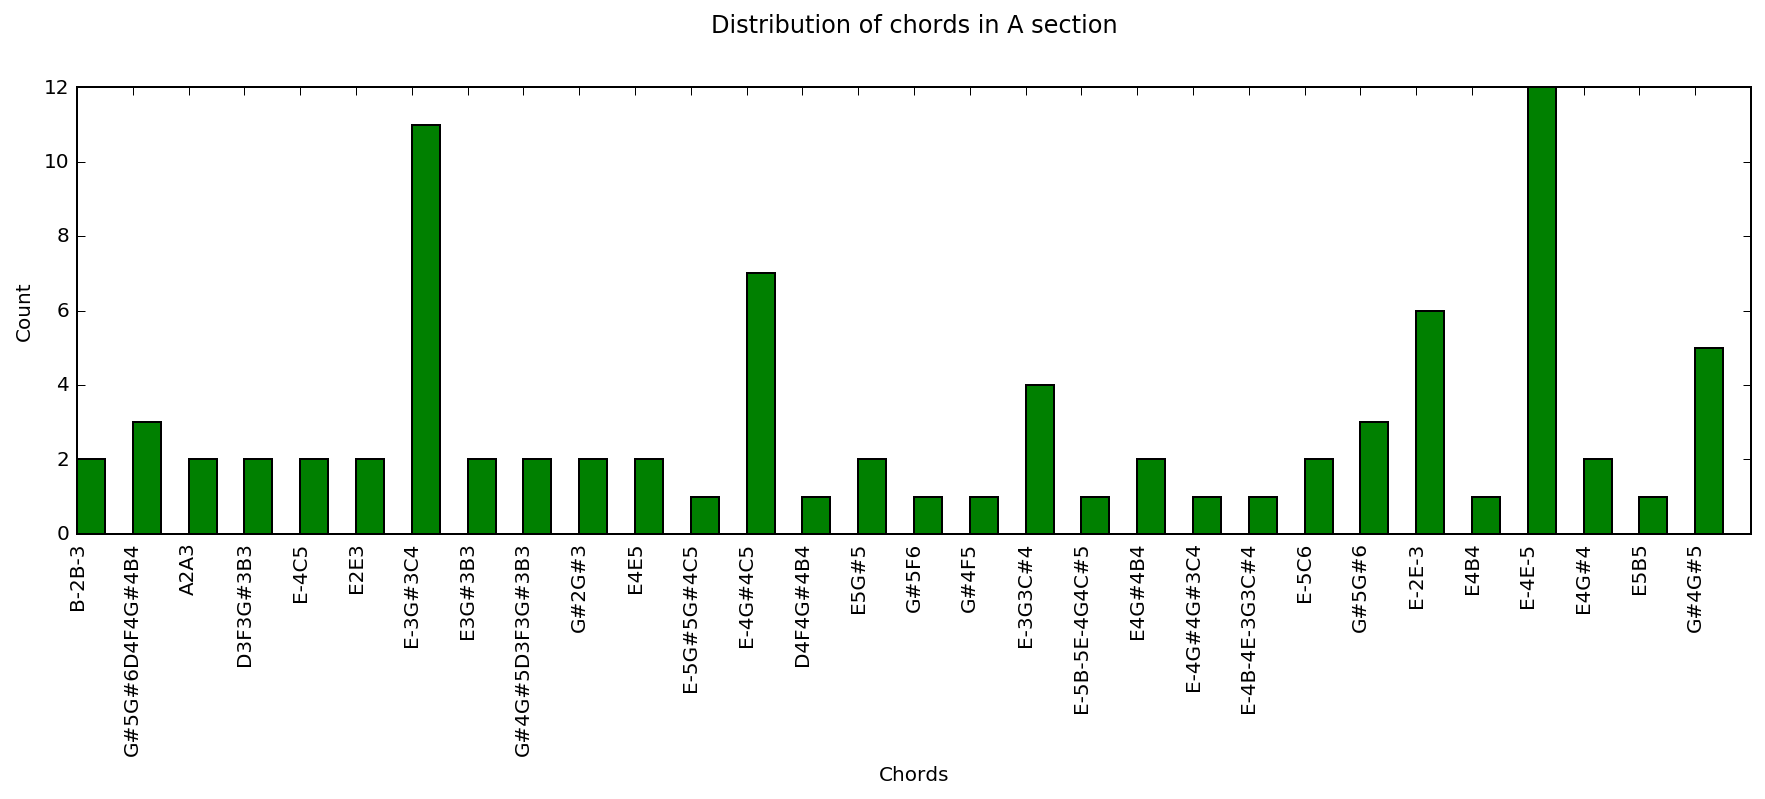

In [23]:
# For each section
#To get distribution of chords within section A
list_of_chords=[]
a_count_elements=0
for item in a.flat:
    a_count_elements+=1
    if(type(item)==chord.Chord):
        notes=[]
        for pitch in item.pitches:
            notes.append(str(pitch))
        list_of_chords.append("".join(notes))
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
a_chords_distribution=Counter(list_of_chords)
print("A section has " + str(a_count_elements)+ " onset events(Notes+Chords)")

# Plotting the distributions
width=0.5
plt.figure(figsize=(15,4))
labels=list(a_chords_distribution.keys())
xaxis=np.arange(0,len(labels))
plt.bar(xaxis, a_chords_distribution.values(), width, color='g')
plt.title('Distribution of chords in A section',y=1.1)
plt.xlabel('Chords')
plt.ylabel('Count')
plt.xticks(xaxis,labels,rotation='vertical')
plt.show()

#### OBSERVATIONS AND INFERENCES

The first section has only 140 onset events(notes+Chords) and is the second lowest in this number among all. The octave unision chord Eflat4+Eflat5(perfect fifth of root key of this peice) is the most frequently occuring chord followed by Eflat+G#3+C4(from G# Major triad).


B section has 146 onset events(Notes+Chords)


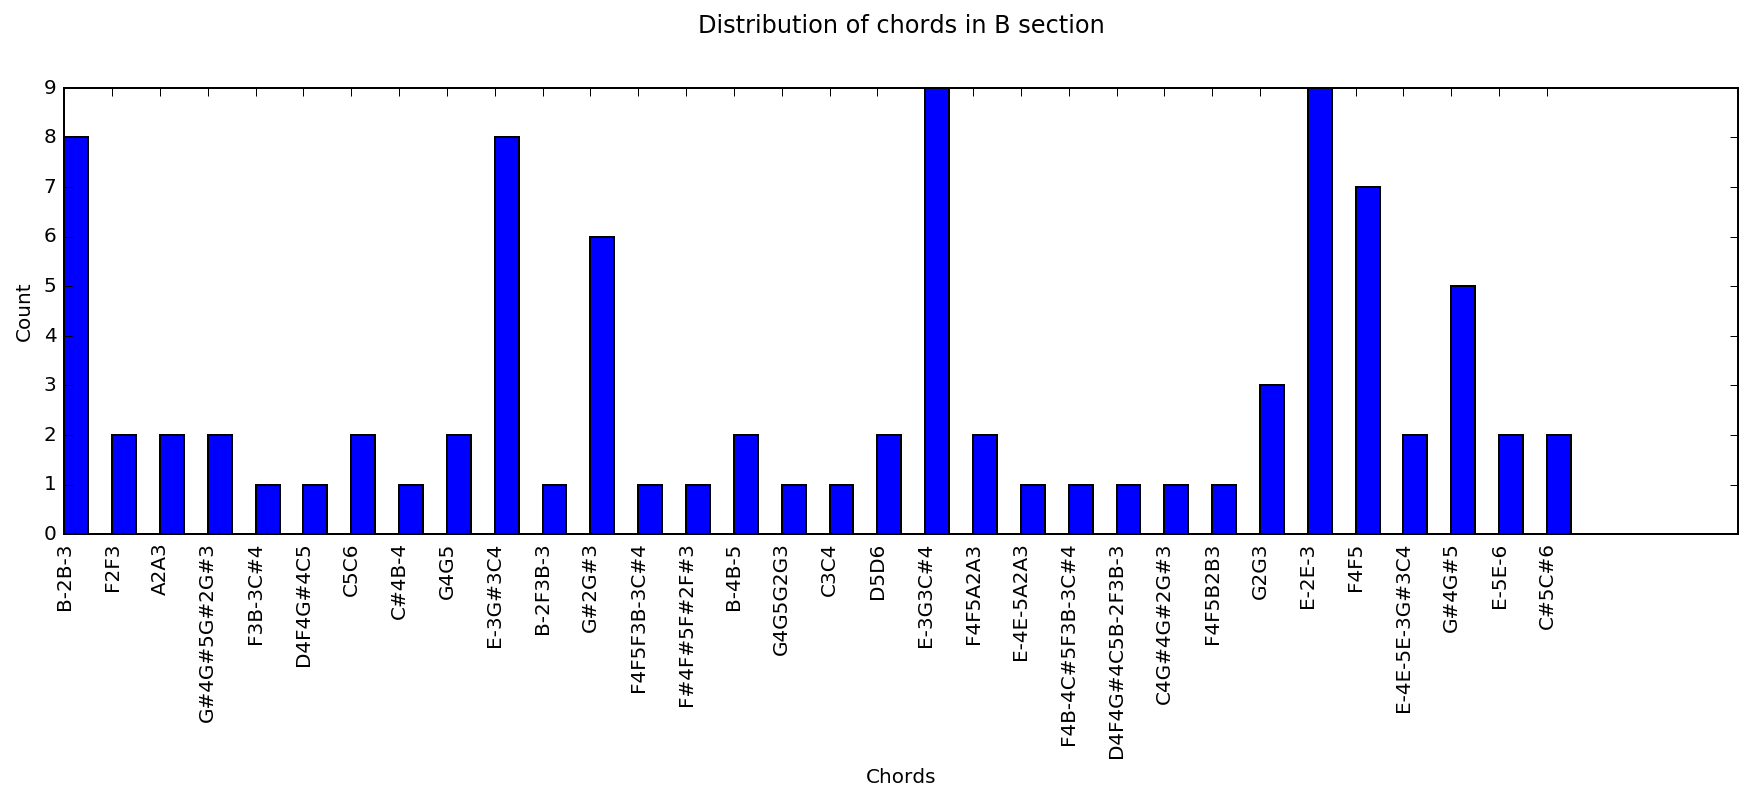

In [24]:
#To get distribution of chords within section B
list_of_chords=[]
b_count_elements=0
for item in b.flat:
    b_count_elements+=1
    if(type(item)==chord.Chord):
        notes=[]
        for pitch in item.pitches:
            notes.append(str(pitch))
        list_of_chords.append("".join(notes))
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
b_chords_distribution=Counter(list_of_chords)
print("B section has " + str(b_count_elements)+ " onset events(Notes+Chords)")

# Plotting the distributions
width=0.5
plt.figure(figsize=(15,4))
labels=list(b_chords_distribution.keys())
xaxis=np.arange(0,len(labels))
plt.bar(xaxis, b_chords_distribution.values(), width, color='b')
plt.title('Distribution of chords in B section',y=1.1)
plt.xlabel('Chords')
plt.ylabel('Count')
plt.xticks(xaxis,labels,rotation='vertical')
plt.show()

#### OBSERVATIONS AND INFERENCES

Section B has the second highest number of onset events - 146, among other sections. This section along with section C are most happening sections as far as the number of onset events are considered. Eflat2+Eflat3(Eflat is the perfect fifth of the root key of the piece Aflat) and Eflat3+G3+C#4 are the chords that appear highest number of times in this section. These are followed by Bflat2+Bflat3 and Eflat2+G#3+C4 which are the second most frequently occuring chords. There is an increase in number of octave unision chords from section A to section B. Eflat3+G3+C#4 chord creates an interesting musical tension.

C section has 159 onset events(Notes+Chords)


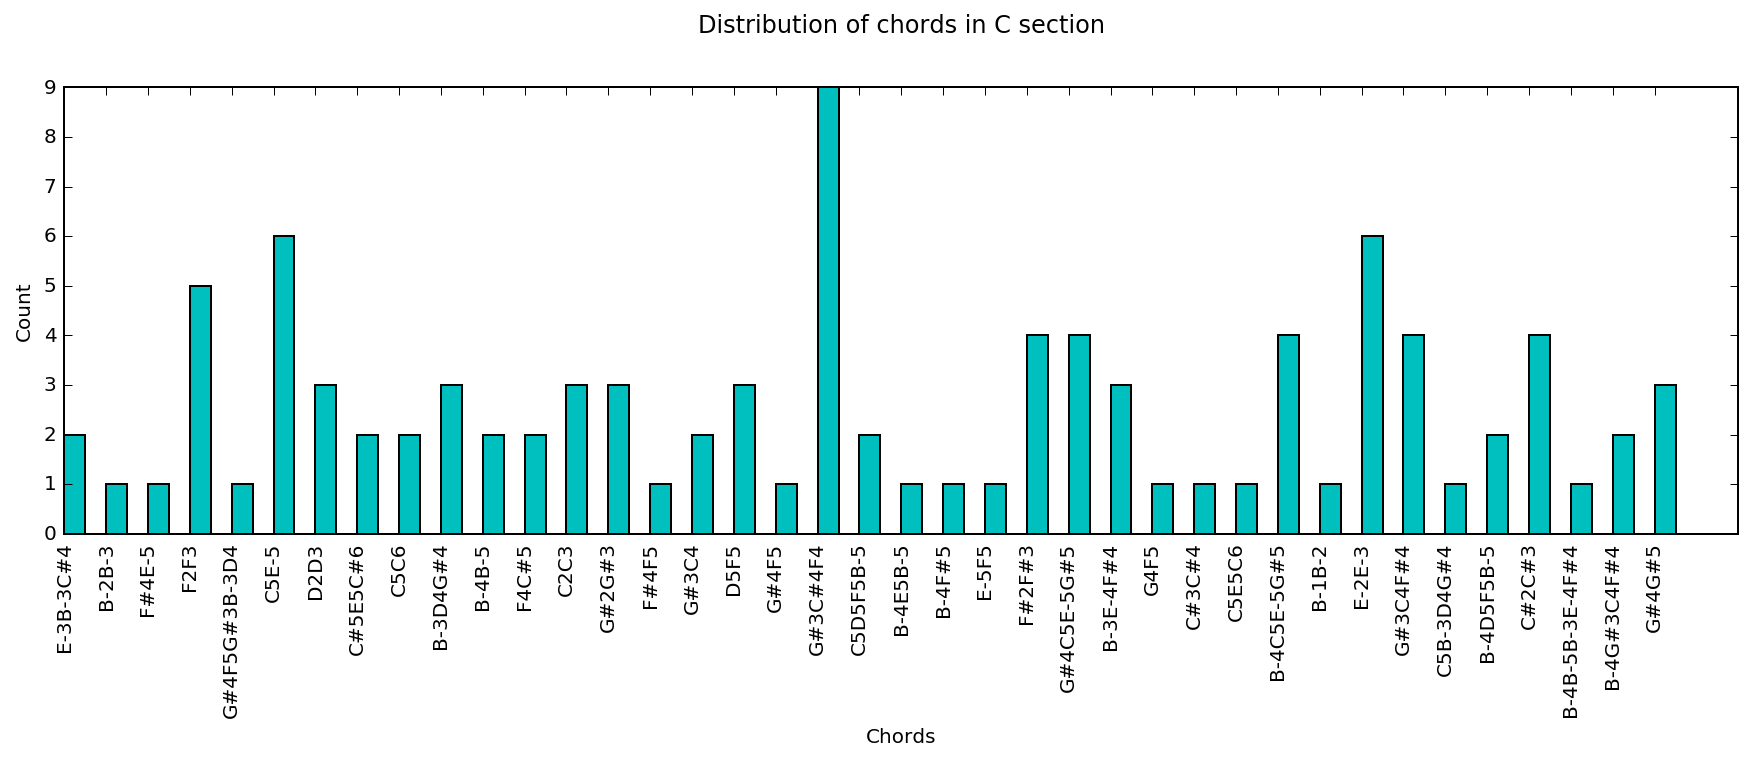

In [25]:
#To get distribution of chords within section C
list_of_chords=[]
c_count_elements=0
for item in c.flat:
    c_count_elements+=1
    if(type(item)==chord.Chord):
        notes=[]
        for pitch in item.pitches:
            notes.append(str(pitch))
        list_of_chords.append("".join(notes))
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
c_chords_distribution=Counter(list_of_chords)
print("C section has " + str(c_count_elements)+ " onset events(Notes+Chords)")

# Plotting the distributions
width=0.5
plt.figure(figsize=(15,4))
labels=list(c_chords_distribution.keys())
xaxis=np.arange(0,len(labels))
plt.bar(xaxis, c_chords_distribution.values(), width, color='c')
plt.title('Distribution of chords in C section',y=1.1)
plt.xlabel('Chords')
plt.ylabel('Count')
plt.xticks(xaxis,labels,rotation='vertical')
plt.show()

#### OBSERVATIONS AND INFERENCES

Section C has the highest number of onset events(notes+chords) : 159, among other sections. Also, this section has the highest number of octave jumps - the octave unision chords. This section is the most happening section since it has the octave jumps and very high number of onset events. G#3C#4F4 shows up the most frequently in this section followed by Efalt2+Eflat3(octave unision chord) and C5+Eflat5(forms major chord triad with the root key note Aflat5). 

D section has 136 onset events(Notes+Chords)


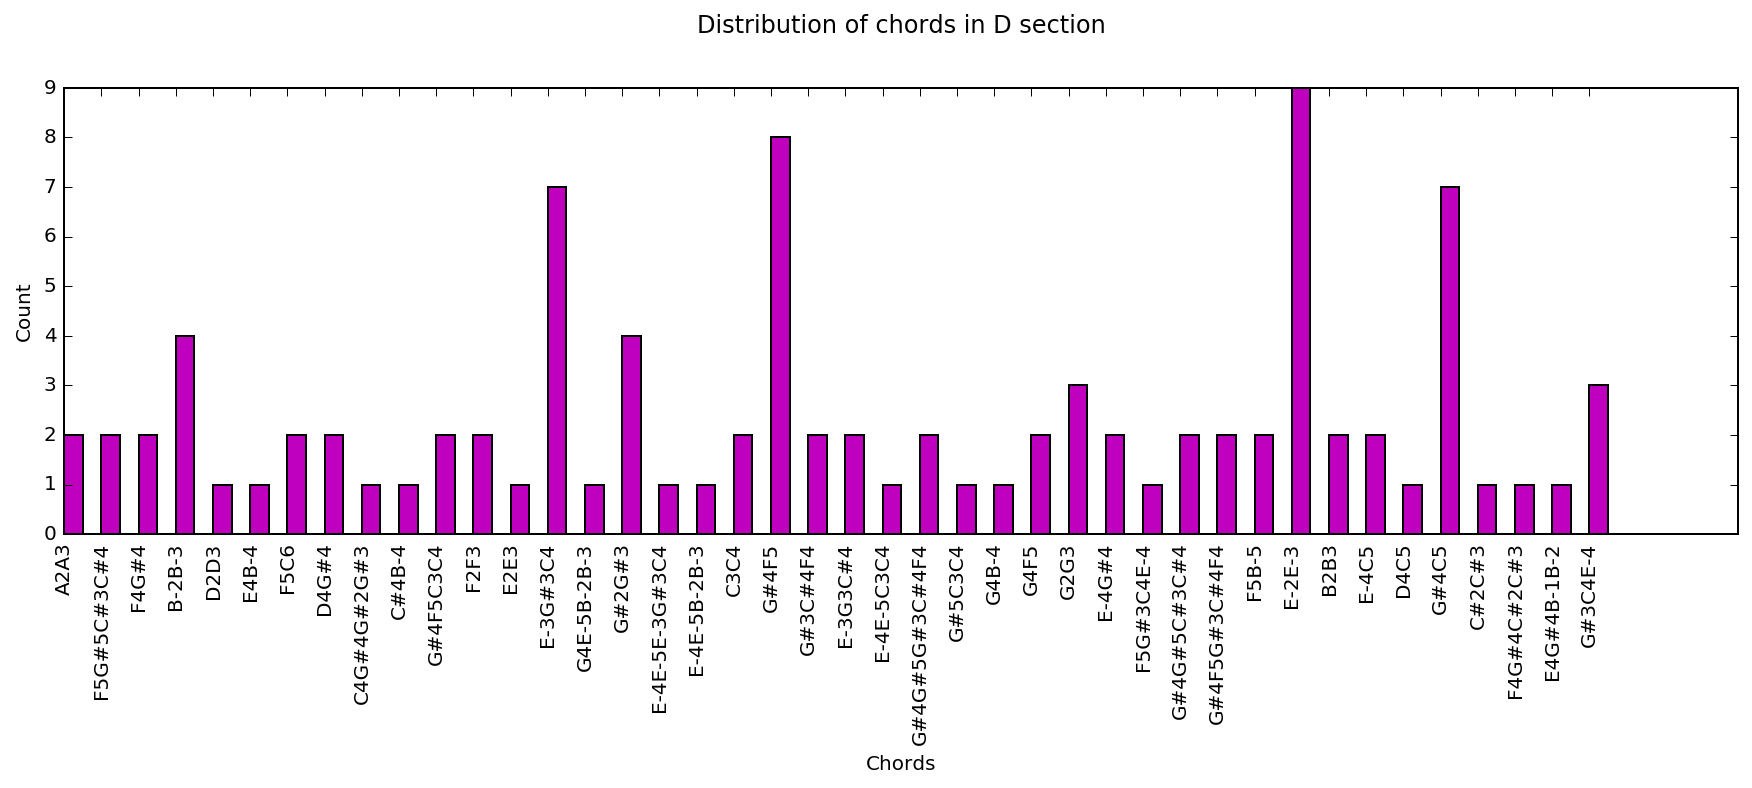

In [26]:
#To get distribution of chords within section D
list_of_chords=[]
d_count_elements=0
for item in d.flat:
    d_count_elements+=1
    if(type(item)==chord.Chord):
        notes=[]
        for pitch in item.pitches:
            notes.append(str(pitch))
        list_of_chords.append("".join(notes))
#Automatically increments value of a key by 1 if the key is present in the dictionary or else key is added to the dictionary                
d_chords_distribution=Counter(list_of_chords)
print("D section has " + str(d_count_elements)+ " onset events(Notes+Chords)")

# Plotting the distributions
width=0.5
plt.figure(figsize=(15,4))
labels=list(d_chords_distribution.keys())
xaxis=np.arange(0,len(labels))
plt.bar(xaxis, d_chords_distribution.values(), width, color='m')
plt.title('Distribution of chords in D section',y=1.1)
plt.xlabel('Chords')
plt.ylabel('Count')
plt.xticks(xaxis,labels,rotation='vertical')
plt.show()

#### OBSERVATIONS AND INFERENCES

D section is the last section of the piece. The octave unision chord Eflat2+Eflat3 ( Eflat is the perfect fifth of the root key of the piece - Aflat) are the most frequent ones followed by G#4+F5 and G#4+C5. There are only 42 different chords in this section and the overall number of chords have gone sightly higher (there were 40 chords in Section C). But Section D has 136 elements(Chords+Notes) and is the smallest section in that way, which is indicative that the piece is slowing down with regard to number of onset events per section and coming to an end.

### FINAL REMARKS

For the best musical experience, it is necessary to listen to the combination of left and right hand parts together. Though, ideally the bassline alone should have been enough to get an approximation of the musical piece, here it is not the case(as we heard in the sample). Also, to experience syncopation we need lead parts sitting on the upbeats. But, when lead portion is played alone, our mind ticks the bassline metronome for us and completes it such a way that we get a better approximation of the musicality of the piece than when bassline was played alone. Even after that, the best musical experience is when both the right and left hand parts are played together since the expectations of a listener's mind are satisfied by the acoustic means. However, for analysis when we used the combination of left and right hand parts, we could not interpret much out of those results. We got more out of the rhythmic analysis when we observed bass and treble parts separately. We got more out of the tonal analysis when we observed individual sections rather than the entire piece. Tonic tensions are created by seventh chords which are relieved by simple major chords in this piece.

<h2 align="center">THE END</h2> 